In [1]:
%load_ext autoreload
%autoreload 2
#* magic to add python path to notebook environment
import sys
pypath = sys.path[0]
%env PYTHONPATH $pypath

import numpy as np

from apps import cex_analyse, cex_toy_generator, cex_toy_parameters, cex_fit_studies, cex_systematics
from python.analysis import cross_section, Plots, Fitting

from IPython.display import clear_output

from rich import print

cross_section.SetPlotStyle(False, dpi = 100, dark = True)

def Analyse(analysis_input : cross_section.AnalysisInput, model : cross_section.pyhf.Model, args : cross_section.argparse.Namespace, energy_slices : cross_section.Slices, mean_track_score_bins : np.array, book : Plots.PlotBook = Plots.PlotBook.null):

    region_fit_result = cex_analyse.RegionFit(analysis_input, energy_slices, mean_track_score_bins, model, mc_stat_unc = args.fit["mc_stat_unc"], single_bin = args.fit["single_bin"])

    _, histograms_reco_obs, histograms_reco_obs_err = cex_analyse.BackgroundSubtraction(analysis_input, args.signal_process, energy_slices, region_fit_result, args.fit["single_bin"], args.fit["regions"], args.toy_template, False, book) #? make separate background subtraction function?


    if args.fit["regions"]:
        histograms_reco_obs = {**histograms_reco_obs, **histograms_reco_obs["int_ex"]}
        histograms_reco_obs.pop("int_ex")
        histograms_reco_obs_err = {**histograms_reco_obs_err, **histograms_reco_obs_err["int_ex"]}
        histograms_reco_obs_err.pop("int_ex")
        # histogram_true_obs = {**histogram_true_obs, **histogram_true_obs["int_ex"]}
        # histogram_true_obs.pop("int_ex")

    unfolding_result = cex_analyse.Unfolding(histograms_reco_obs, histograms_reco_obs_err, args.toy_template, args.unfolding, args.signal_process, len(analysis_input.KE_init_reco)/len(args.toy_template.KE_init_reco), energy_slices, args.fit["regions"], args.fit["mc_stat_unc"], None, book)

    if book is not None:
        for p in cex_analyse.process_labels:
            hist_true = analysis_input.CreateHistograms(args.energy_slices, p, False, None)["int_ex"]
            Plots.Plot(args.energy_slices.pos_overflow, unfolding_result[p]["unfolded"], yerr = cross_section.quadsum([unfolding_result[p]["stat_err"], unfolding_result[p]["sys_err"]], 0), xlabel = f"$N_{{int, {cex_analyse.process_labels[p]}}}$ (MeV)", ylabel = "Counts", label = "unfolded", style = "step", color = "C6")
            Plots.Plot(args.energy_slices.pos_overflow, hist_true, label = "true", style = "step", color = "C0", newFigure = False)
            book.Save()

    xs = cex_analyse.XSUnfold(unfolding_result, args.energy_slices, True, True, args.fit["regions"])
    return xs 


def CreateConfig(PDSP : int = 1, p_init : float = 1000, events : int = 50805, seed : int = None, verbose : bool = False, modified_PDFs : dict[np.array] = None, scale_factors : dict[float] = None, smearing : str = "double_crystal_ball", step : float = 2, beam_profile : str = "gaussian", max_cpus : int = 11):
    return {
    "events" : events,
    "step" : step,
    "p_init" : p_init,
    "beam_profile" : beam_profile,
    "beam_width" : 60,

    "smearing_params" : {
        "KE_init" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_init/{smearing}.json",
        "KE_int" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_int/{smearing}.json",
        "z_int" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/z_int/{smearing}.json"
    },
    "reco_region_fractions" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/reco_regions/reco_region_fractions.hdf5",
    "beam_selection_efficiencies" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/pi_beam_efficiency/beam_selection_efficiencies_true.hdf5",
    "mean_track_score_kde" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/meanTrackScoreKDE/kdes.dill",
    "pdf_scale_factors" : scale_factors,
    "verbose" : verbose,
    "seed" : seed,
    "modified_PDFs" : modified_PDFs,
    "max_cpus" : max_cpus
    }


def SysErr(nominal, modified):
    res = np.nan_to_num(nominal - modified)

    low = res > 0 # the nominal value is higher than the modified, so the change is small
    high = ~low
    
    err_low = abs(np.where(low, res, 0))
    err_high = abs(np.where(high, res, 0))
    

    return err_low, err_high


env: PYTHONPATH=/home/sb16165/Documents/pi0-analysis/analysis


# Load data

In [2]:
args = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration("work/2023/beam_selections/new_selection_true/analysis_config.json"))
args.toy_template = cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(file = "work/2023/analysis_2GeV_new_pfo_selection/toy_template_2cm.hdf5"))
energy_overflow = args.energy_slices.pos_overflow

In [3]:
cfg = cross_section.LoadConfiguration("work/2023/analysis_2GeV_new_pfo_selection/toy_data_config.json")
cfg["seed"] = None
cfg["events"] = 20000
toy_template = cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(df = cex_toy_generator.run(cfg)))
cfg["events"] = 56000
toy_data = cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(df = cex_toy_generator.run(cfg)))


starting batch : 0, cpus : 2

Simulating |████████████████████████████████████████| 1/1 [100%] in 2.4s (0.42/s) 


Done! Creating dataframe...

total_inelastic 20000

quasielastic 6321

pion_production 9398

charge_exchange 1836

absorption 1386

double_charge_exchange 1059

'BeamSelectionEfficiency' executed in 0.0077s

'GenerateRecoRegions' executed in 0.0357s

'MeanTrackScore' executed in 0.1241s

'main' executed in 2.6844s

starting batch : 0, cpus : 6

Simulating |████████████████████████████████████████| 1/1 [100%] in 3.2s (0.32/s) 


Done! Creating dataframe...

total_inelastic 55999

decay 1

charge_exchange 5167

quasielastic 17534

pion_production 26545

absorption 3706

double_charge_exchange 3047

1

'BeamSelectionEfficiency' executed in 0.0059s

'GenerateRecoRegions' executed in 0.0768s

'MeanTrackScore' executed in 0.2784s

'main' executed in 3.7249s

In [7]:
model = cross_section.RegionFit.CreateModel(toy_template, args.energy_slices, args.fit["mean_track_score"], False, None, True, True, args.fit["single_bin"])

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']
     nbins: {'channel_0': 1, 'channel_1': 1, 'channel_2': 1, 'channel_3': 1}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('channel_0_stat_err', 'staterror'), ('channel_1_stat_err', 'staterror'), ('channel_2_stat_err', 'staterror'), ('channel_3_stat_err', 'staterror'), ('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['channel_0_stat_err', 'channel_1_stat_err', 'channel_2_stat_err', 'channel_3_stat_err', 'mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 4
   auxdata: [1.0, 1.0, 1.0, 1.0]


In [8]:
delta_cv = []
unc = []
unc_fixed = []
tol = np.logspace(-2, -7, 20)
for t in tol:
    obs = cross_section.RegionFit.GenerateObservations(toy_data, args.energy_slices, None, model, single_bin = args.fit["single_bin"])
    res = cross_section.RegionFit.Fit(obs, model, tolerance = t, verbose = False)
    res_fixed = cross_section.RegionFit.Fit(obs, model, fix_pars = [False, False, False, False, True, True, True, True], init_params = [1, 1, 1, 1, *res.bestfit[4:]], tolerance = t, verbose = False)
    delta_cv.append(abs(res_fixed.bestfit - res.bestfit))
    unc.append(abs(res.uncertainty))
    unc_fixed.append(abs(res_fixed.uncertainty))

delta_cv = np.array(delta_cv)
unc = np.array(unc)
unc_fixed = np.array(unc_fixed)

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-21674.66321155])
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-21674.66321155])
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-21674.66321155])
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-21674.66321155])
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-21674.66321155])
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-21674.66321155])
model.config.sug

pdf fit_test.pdf has been opened
pdf fit_test.pdf has been closed


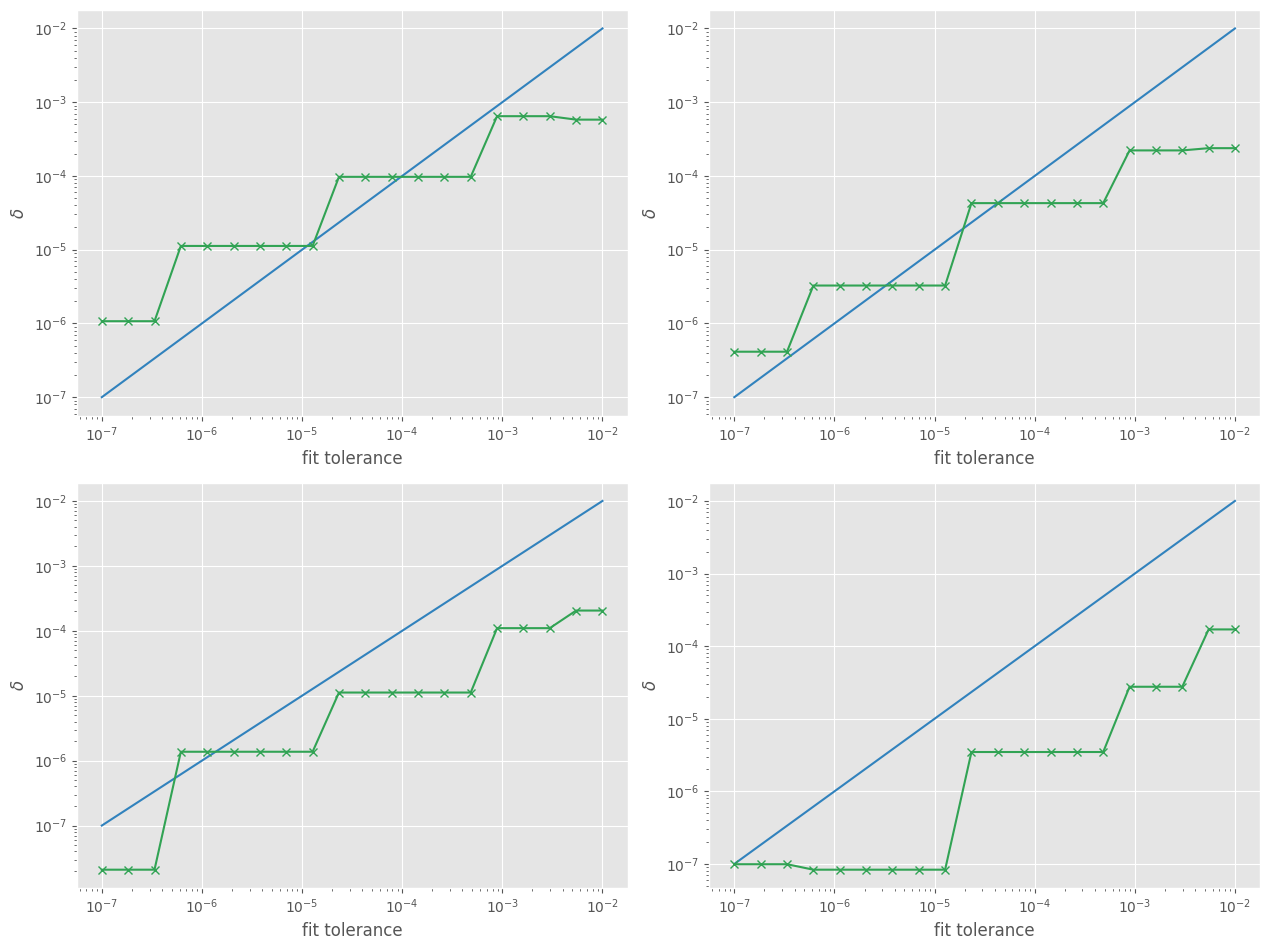

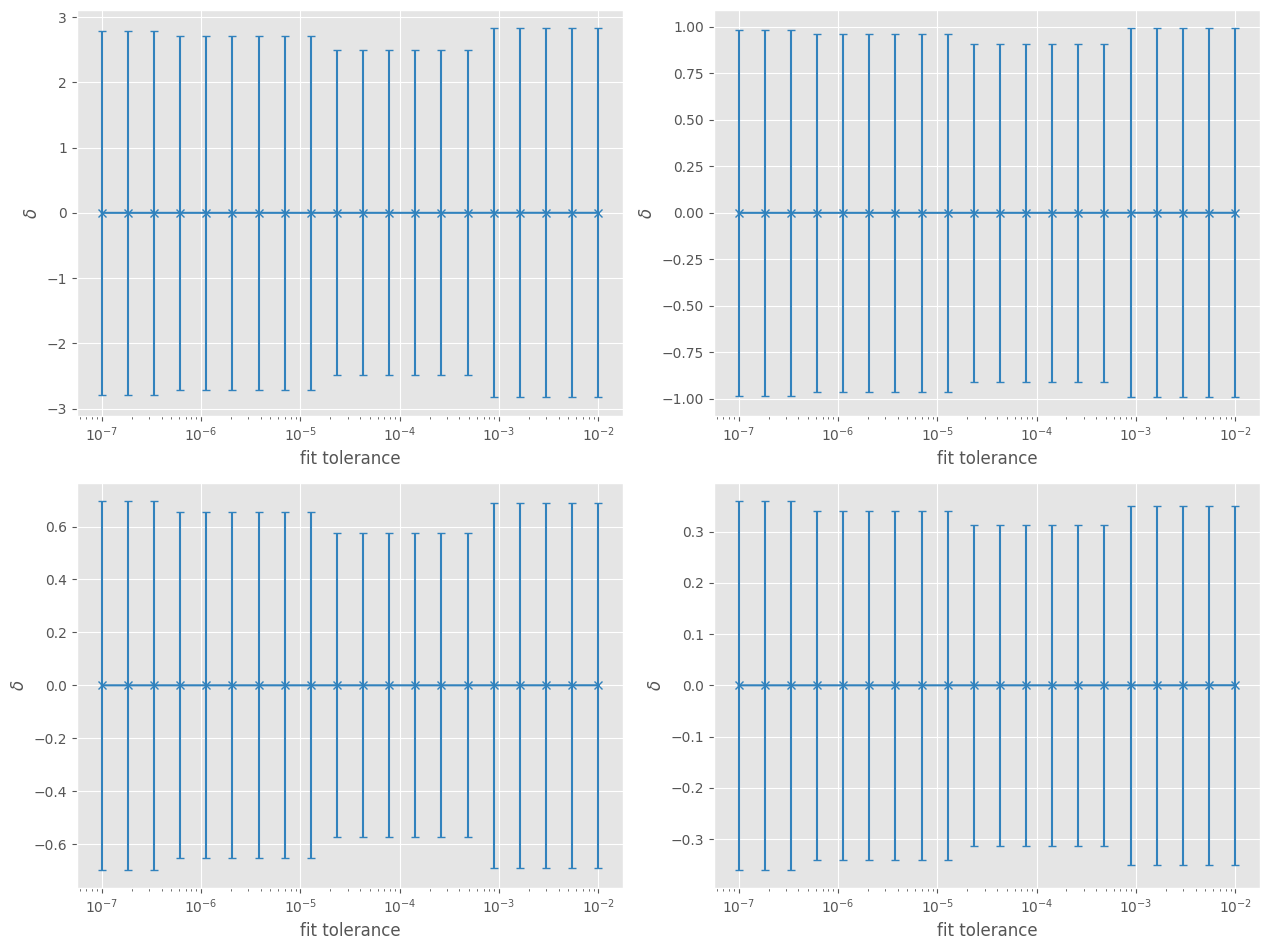

In [42]:
with Plots.PlotBook("fit_test.pdf") as book:
    for i in Plots.MultiPlot(4):
        Plots.Plot([min(tol), max(tol)], [min(tol), max(tol)], newFigure = False)
        Plots.Plot(tol, delta_cv[:, i], newFigure = False, y_scale = "log", x_scale = "log", xlabel = "fit tolerance", ylabel = "$\delta$", marker = "x")
    book.Save()

    for i in Plots.MultiPlot(4):
        Plots.Plot(tol, delta_cv[:, i], newFigure = False, y_scale = "linear", x_scale = "log", xlabel = "fit tolerance", ylabel = "$\delta$", marker = "x", yerr = unc[:, i])
    book.Save()
    

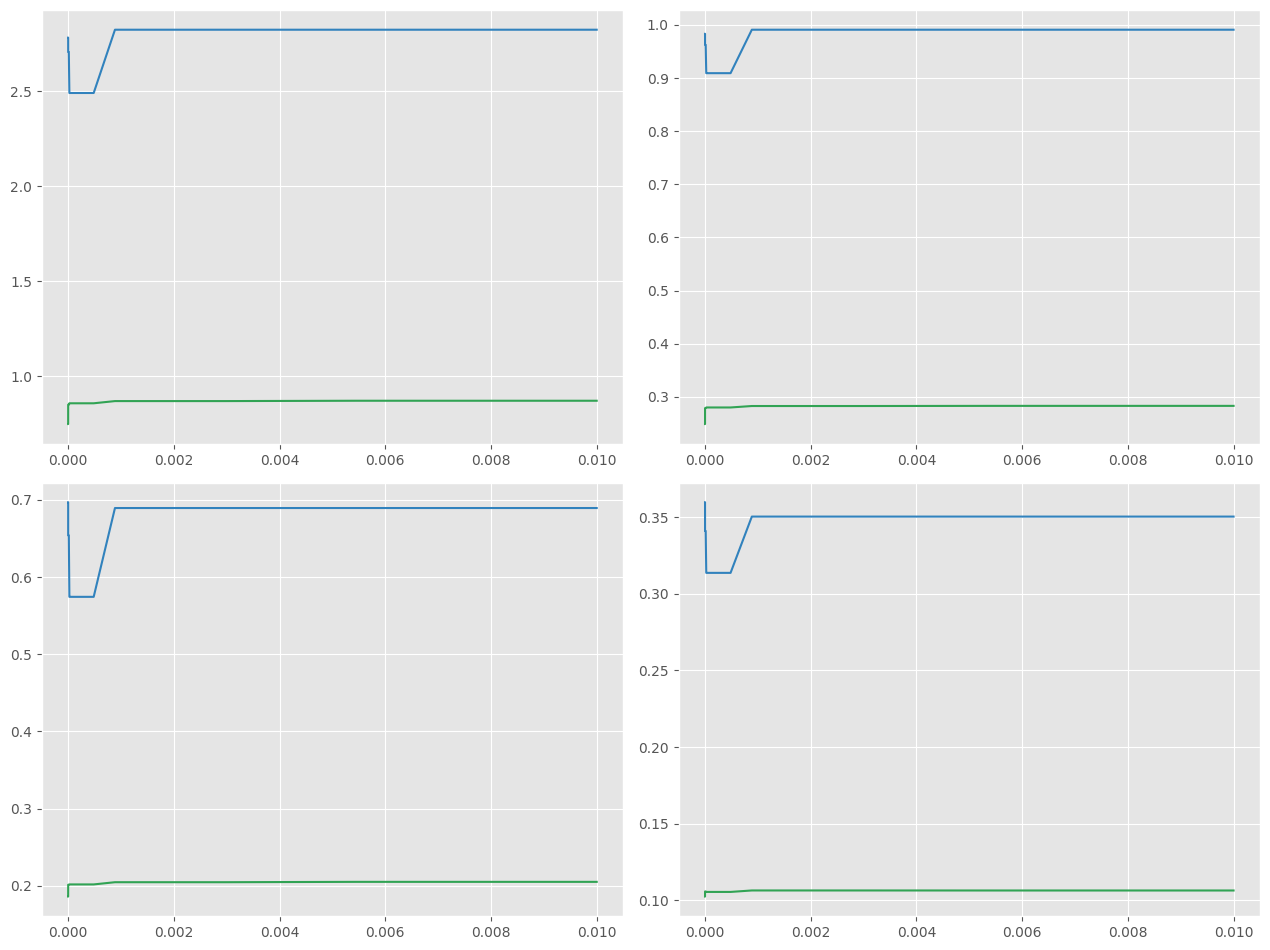

In [47]:
for i in Plots.MultiPlot(4):
    Plots.Plot(tol, unc[:, i], newFigure = False)
    Plots.Plot(tol, unc_fixed[:, i], newFigure = False)

In [20]:
print(res_fixed.bestfit)
print(res.bestfit)

# print(res_fixed.uncertainty)
# print(res.uncertainty)

# print(res.best_twice_nll)
# print(res_fixed.best_twice_nll)

[4.7239278  2.37513102 1.95231766 3.27450631 0.99999995 0.99999956
 0.99999999 0.99999994]

[4.72392758 2.37513076 1.95231756 3.27450646 0.99999995 0.99999956
 0.99999999 0.99999994]

[ 2.22775740e-07  2.56171653e-07  9.58329271e-08 -1.49447689e-07
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]

In [3]:
model = cross_section.RegionFit.CreateModel(args.toy_template, args.energy_slices, args.fit["mean_track_score"], False, None, args.fit["mc_stat_unc"], True, args.fit["single_bin"])

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']
     nbins: {'channel_0': 1, 'channel_1': 1, 'channel_2': 1, 'channel_3': 1}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 0
   auxdata: []


In [4]:
toy_config_nominal = cross_section.LoadConfiguration("work/2023/analysis_2GeV_new_pfo_selection/toy_data_config.json")
toy_config_nominal["seed"] = 1
toy_config_nominal["max_cpus"] = 10
toy_config_nominal["events"] = int(5E4)
toy_config_nominal["verbose"] = False

In [5]:
toy_nominal = cross_section.Toy(df = cex_toy_generator.run(toy_config_nominal))

Simulating |████████████████████████████████████████| 1/1 [100%] in 3.9s (0.26/s) 


'BeamSelectionEfficiency' executed in 0.0051s

'GenerateRecoRegions' executed in 0.0837s

'MeanTrackScore' executed in 0.2796s

'main' executed in 4.5582s

In [ ]:
analysis_input_nominal = cross_section.AnalysisInput.CreateAnalysisInputToy(toy_nominal)
with Plots.PlotBook("xs_nominal", False) as book:
    xs_nominal = Analyse(analysis_input_nominal, model, args, args.energy_slices, None, None)

# MC Stat uncertainty

In [16]:
def PseudoExperiment(n_experiments, n_data, n_template):
    data_config = {k : v for k, v in toy_config_nominal.items()}
    data_config["seed"] = None
    data_config["events"] = n_data

    template_config = {k : v for k, v in toy_config_nominal.items()}
    template_config["seed"] = None
    template_config["events"] = n_template

    xs = []
    for i in range(n_experiments):
        print(f"{i=}")
        ai_template = cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(df = cex_toy_generator.run(template_config)))
        ai_data = cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(df = cex_toy_generator.run(data_config)))
        xs.append(Analyse(ai_data, ai_template, args, args.energy_slices, None, None))
        clear_output()        

    return np.array(xs)

n_experiments = 101
n_data = 72780
n_template = 29452

xs = PseudoExperiment(n_experiments, n_data, n_template)

In [33]:
cross_section.SaveObject("test/mc_stat_results.dill", xs)

[ 197.55162786   44.48241306   23.86933826   13.75573954   11.01124382
   11.0247282    11.37993186   15.63823666   18.54181752   23.8417464
   31.20114062   41.7196889    44.78570444 2252.82976052]

[ 165.31481988   49.5700049    41.69310365   45.94448584   50.52706997
   54.3725391    59.37011065   63.19353946   70.26495323   74.90966112
   86.46898951   90.01963669   87.43404877 4735.94521514]

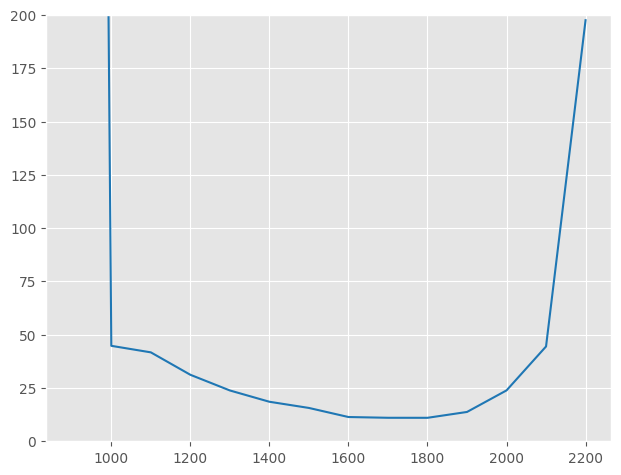

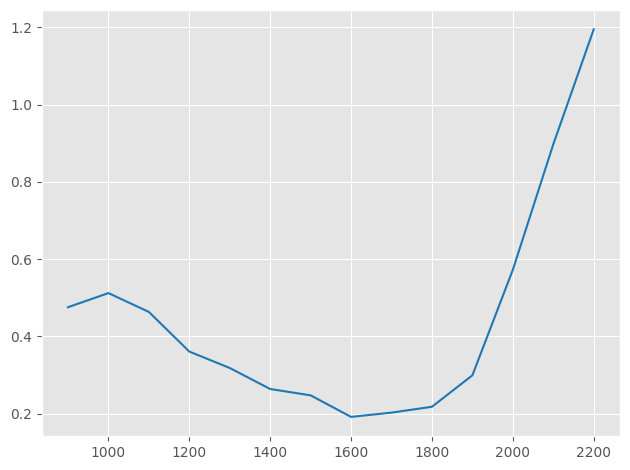

In [27]:
# cv = xs[0][0]
cv = np.nanmean(xs[:, 0], 0)
res = xs[:, 0] - cv

mean = np.nanmean(abs(res), 0)
print(mean)
print(cv)
Plots.Plot(args.energy_slices.pos, mean)
Plots.plt.ylim(0, 200)

Plots.Plot(args.energy_slices.pos, mean/cv)

# MC stat visualisation

In [94]:
mc_stat = cex_systematics.NuisanceParameters(args)
result = mc_stat.RunExperiment()

loading Data and MC

analysing pdsp

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:890: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']
     nbins: {'channel_0': 1, 'channel_1': 1, 'channel_2': 1, 'channel_3': 1}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 0
   auxdata: []
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-14386.98666643])


fit_values.bestfit=array([2.43430031, 2.92062387, 1.84990259, 3.21208581])

init
Iteration 1: ts = 0.0089, ts_stopping = 0.0001
Iteration 2: ts = 0.0053, ts_stopping = 0.0001
Iteration 3: ts = 0.0033, ts_stopping = 0.0001
Iteration 4: ts = 0.0020, ts_stopping = 0.0001
Iteration 5: ts = 0.0013, ts_stopping = 0.0001
Iteration 6: ts = 0.0008, ts_stopping = 0.0001
int
Iteration 1: ts = 0.0090, ts_stopping = 0.0001
Iteration 2: ts = 0.0044, ts_stopping = 0.0001
Iteration 3: ts = 0.0022, ts_stopping = 0.0001
Iteration 4: ts = 0.0011, ts_stopping = 0.0001
Iteration 5: ts = 0.0009, ts_stopping = 0.0001
Iteration 6: ts = 0.0009, ts_stopping = 0.0001
absorption
Iteration 1: ts = 0.0727, ts_stopping = 0.0001
Iteration 2: ts = 0.0421, ts_stopping = 0.0001
Iteration 3: ts = 0.0223, ts_stopping = 0.0001
Iteration 4: ts = 0.0124, ts_stopping = 0.0001
Iteration 5: ts = 0.0074, ts_stopping = 0.0001
Iteration 6: ts = 0.0047, ts_stopping = 0.0001
charge_exchange
Iteration 1: ts = 0.0350, ts_stopping = 0.0001
Iteration 2: ts = 0.0162, ts_stopping = 0.0001
Iteration 3: ts = 0.0076

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:1812: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  Plots.plt.figure()
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:994: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:890: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


process={'absorption': (array([  7.21095308,  38.98004224,  37.46552137, 115.80717857]), array([15.12313585,  
8.95227579,  7.40106294, 25.98938524])), 'charge_exchange': (array([ 9.74621835, 47.1336058 , 86.36307738, 
65.73993322]), array([19.54598267,  6.73643079,  9.28131635, 17.88053757])), 'single_pion_production': 
(array([102.67537968, 114.22325528, 168.83323982, 210.33679827]), array([37.06893168, 12.29486343, 15.69297158, 
43.31816799])), 'pion_production': (array([263.51734124, 323.07945402, 305.30986871, 227.0195897 ]), 
array([43.15790883, 16.58030195, 20.09100234, 45.60585293]))}

loading Data and MC

analysing pdsp

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']
     nbins: {'channel_0': 1, 'channel_1': 1, 'channel_2': 1, 'channel_3': 1}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('channel_0_stat_err', 'staterror'), ('channel_1_stat_err', 'staterror'), ('channel_2_stat_err', 'staterror'), ('channel_3_stat_err', 'staterror'), ('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['channel_0_stat_err', 'channel_1_stat_err', 'channel_2_stat_err', 'channel_3_stat_err', 'mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 4
   auxdata: [1.0, 1.0, 1.0, 1.0]
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-14377.52965367])


fit_values.bestfit=array([2.43425868, 2.92093812, 1.84983707, 3.212184  , 1.0000125 ,
       0.9999512 , 1.0000011 , 0.99998219])

init
Iteration 1: ts = 0.0089, ts_stopping = 0.0001
Iteration 2: ts = 0.0053, ts_stopping = 0.0001
Iteration 3: ts = 0.0033, ts_stopping = 0.0001
Iteration 4: ts = 0.0020, ts_stopping = 0.0001
Iteration 5: ts = 0.0013, ts_stopping = 0.0001
Iteration 6: ts = 0.0008, ts_stopping = 0.0001
int
Iteration 1: ts = 0.0090, ts_stopping = 0.0001
Iteration 2: ts = 0.0044, ts_stopping = 0.0001
Iteration 3: ts = 0.0022, ts_stopping = 0.0001
Iteration 4: ts = 0.0011, ts_stopping = 0.0001
Iteration 5: ts = 0.0009, ts_stopping = 0.0001
Iteration 6: ts = 0.0009, ts_stopping = 0.0001
absorption
Iteration 1: ts = 0.0727, ts_stopping = 0.0001
Iteration 2: ts = 0.0421, ts_stopping = 0.0001
Iteration 3: ts = 0.0223, ts_stopping = 0.0001
Iteration 4: ts = 0.0124, ts_stopping = 0.0001
Iteration 5: ts = 0.0074, ts_stopping = 0.0001
Iteration 6: ts = 0.0047, ts_stopping = 0.0001
charge_exchange
Iteration 1: ts = 0.0350, ts_stopping = 0.0001
Iteration 2: ts = 0.0162, ts_stopping = 0.0001
Iteration 3: ts = 0.0076

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:1812: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  Plots.plt.figure()
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:994: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:890: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


process={'absorption': (array([  7.20823448,  38.97780516,  37.46344196, 115.8060796 ]), array([17.82939624, 
16.69163708, 14.31004673, 50.84468997])), 'charge_exchange': (array([ 9.74962515, 47.13591284, 86.3654869 , 
65.74240254]), array([22.38075857, 10.84375665, 15.41243464, 30.69086897])), 'single_pion_production': 
(array([102.6662501 , 114.21853749, 168.83002086, 210.33539918]), array([54.95423561, 23.74963405, 31.137077  , 
87.07090596])), 'pion_production': (array([263.51866541, 323.08167489, 305.31196727, 227.02250077]), 
array([98.04515413, 35.03553373, 42.15096423, 94.20302778]))}

In [95]:
mc_stat_err = mc_stat.CalculateSysError(result)
print(mc_stat_err)

{
    'absorption': array([ 9.44341742, 14.08784961, 12.24751831, 43.70050747]),
    'charge_exchange': array([10.90196844,  8.49750308, 12.30448326, 24.94425413]),
    'single_pion_production': array([40.56922867, 20.31948451, 26.89327438, 75.53064932]),
    'pion_production': array([88.03548804, 30.86393058, 37.05476231, 82.42764476])
}

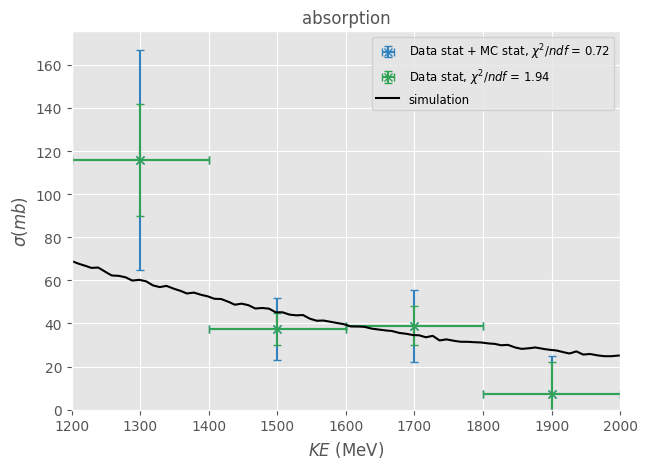

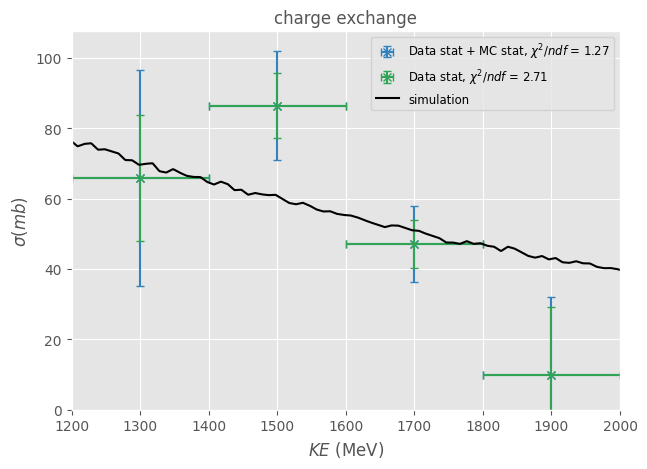

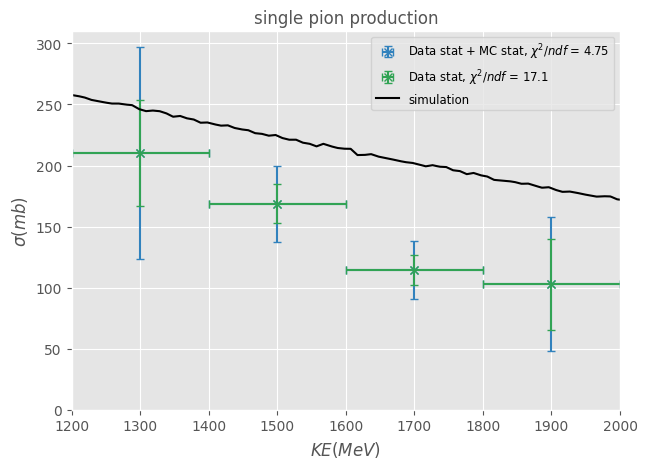

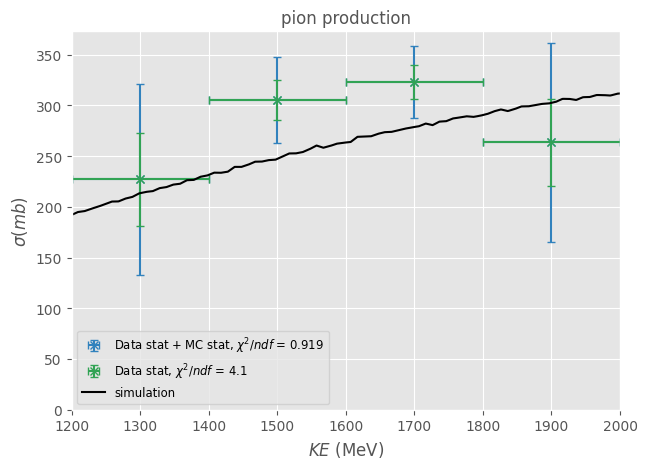

In [97]:
mc_stat.PlotXSMCStat(result)

In [98]:
import pandas as pd

tables = mc_stat.MCStatTables(result)

In [103]:
tables["absorption"].style.format(precision = 2).to_latex()

'\\begin{tabular}{llll}\n & $KE$ (MeV) & Data stat & MC stat \\\\\n0 & 1900 & 2.10 & 1.31 \\\\\n1 & 1700 & 0.23 & 0.36 \\\\\n2 & 1500 & 0.20 & 0.33 \\\\\n3 & 1300 & 0.22 & 0.38 \\\\\n0 & average & 0.69 & 0.59 \\\\\n\\end{tabular}\n'

# Region fit normalisation systematic

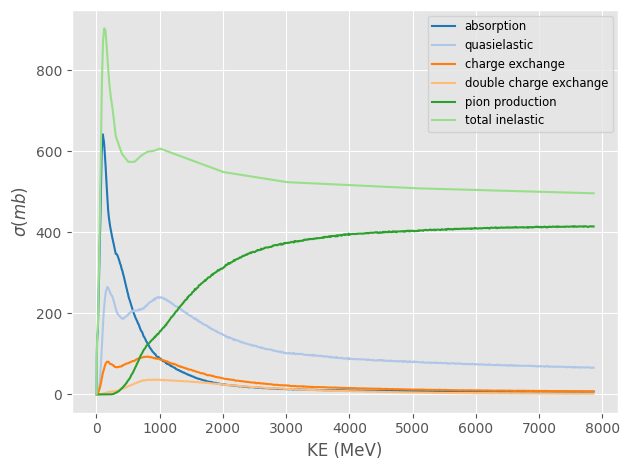

In [8]:
xs = cex_toy_generator.ModifyGeantXS(scale_factors = {"absorption" : 1, "charge_exchange" : 1, "pion_production" : 1, "double_charge_exchange" : 1, "quasielastic" : 1}, modified_PDFs = None)
xs.Plot("all")

In [ ]:
def NormalisationSystematic(data_config : dict, norms = [0.8, 1.2], plot : bool = False):
    x = args.energy_slices.pos[:-1] - args.energy_slices.width / 2

    exclusive_proc = ["absorption", "charge_exchange", "single_pion_production", "pion_production"]
    cvs = {}
    true_cvs = {}
    for target in exclusive_proc:
        print(f"{target=}")
        scales = {k : 1 for k in ['absorption', 'quasielastic', 'charge_exchange', 'double_charge_exchange', 'pion_production']}
        xs = {}
        xs_true = {}
        for i in norms:
            if i == 1:
                config = {k : v for k,v in data_config.items()}
            else:
                if target == "single_pion_production":
                    scales["quasielastic"] = i
                    scales["double_charge_exchange"] = i
                else:
                    scales[target] = i
                config = cex_fit_studies.CreateConfigNormalisation(scales, data_config)
            ai = cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(df = cex_toy_generator.run(config)))
            
            if plot is True:
                out = f"test/normalisation_systematic/{target}/"
                cross_section.os.makedirs(out, exist_ok = True)
                book = Plots.PlotBook(f"{out}plots_{i}")
            else:
                book = None

            xs[i] = Analyse(ai, model, args, args.energy_slices, None, book)
            if plot is True:
                book.close()
                Plots.plt.close("all")
            xs_sim_mod = cex_toy_generator.ModifyGeantXS(scale_factors = config["pdf_scale_factors"])

            if args.fit["regions"]:
                xs_true[i] = {k : xs_sim_mod.GetInterpolatedCurve(k)(x) for k in exclusive_proc}
            else:
                xs_true[i] = xs_sim_mod.GetInterpolatedCurve(args.signal_process)(x)
        cvs[target] = xs
        true_cvs[target] = xs_true
    return cvs, true_cvs

norm_sys = cex_systematics.NormalisationSystematic(args, model, toy_config_nominal)
results = norm_sys.Evaluate([0.8, 1.2], 3)

In [125]:
cross_section.SaveObject("test/normsys.dill", results)

In [31]:
results = cross_section.LoadObject("work/2023/beam_selections/new_selection_true/new_bins/systematics/theory/test_results.dill")
cex_systematics.NormalisationSystematic.AverageResults(results)

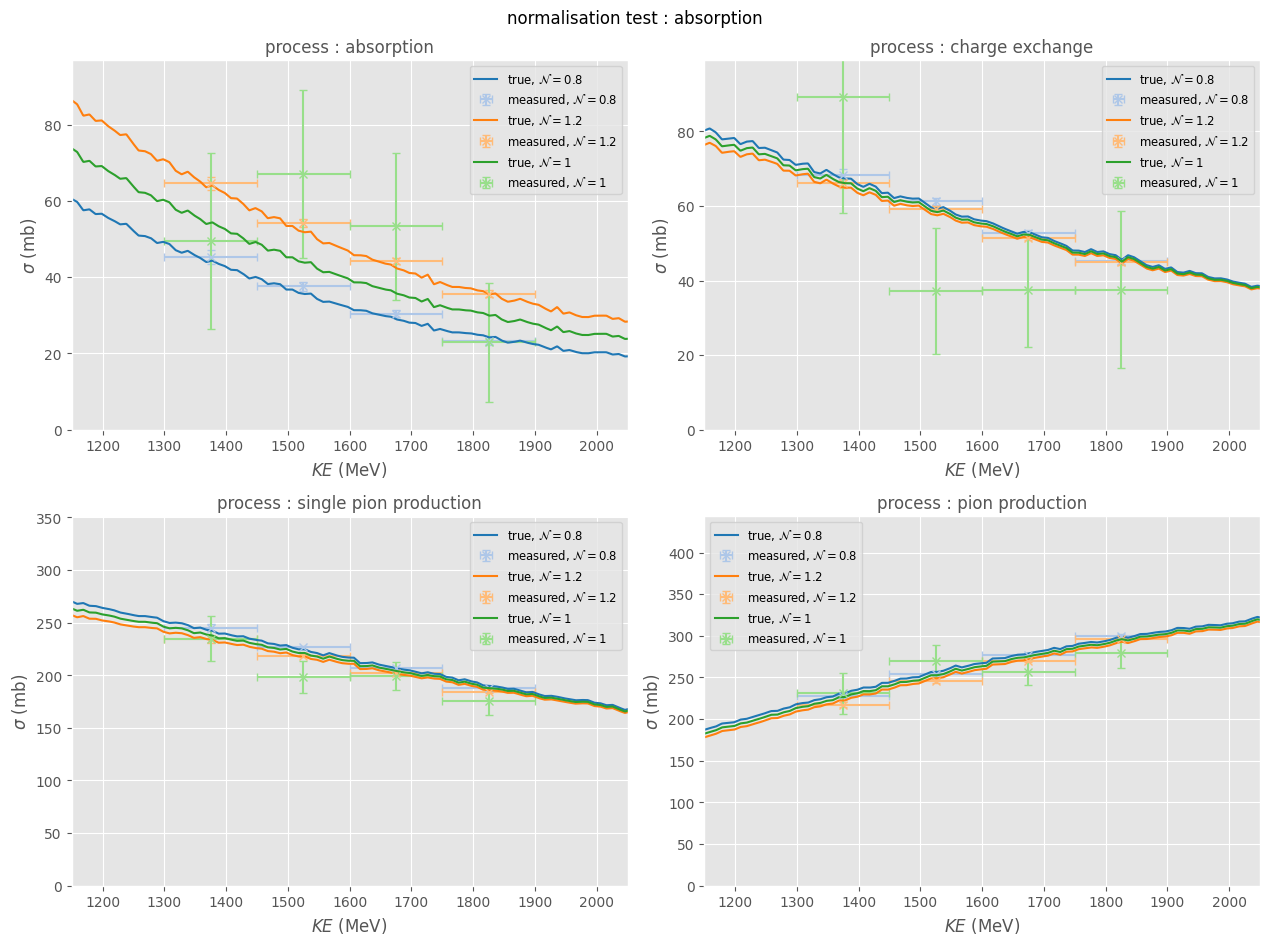

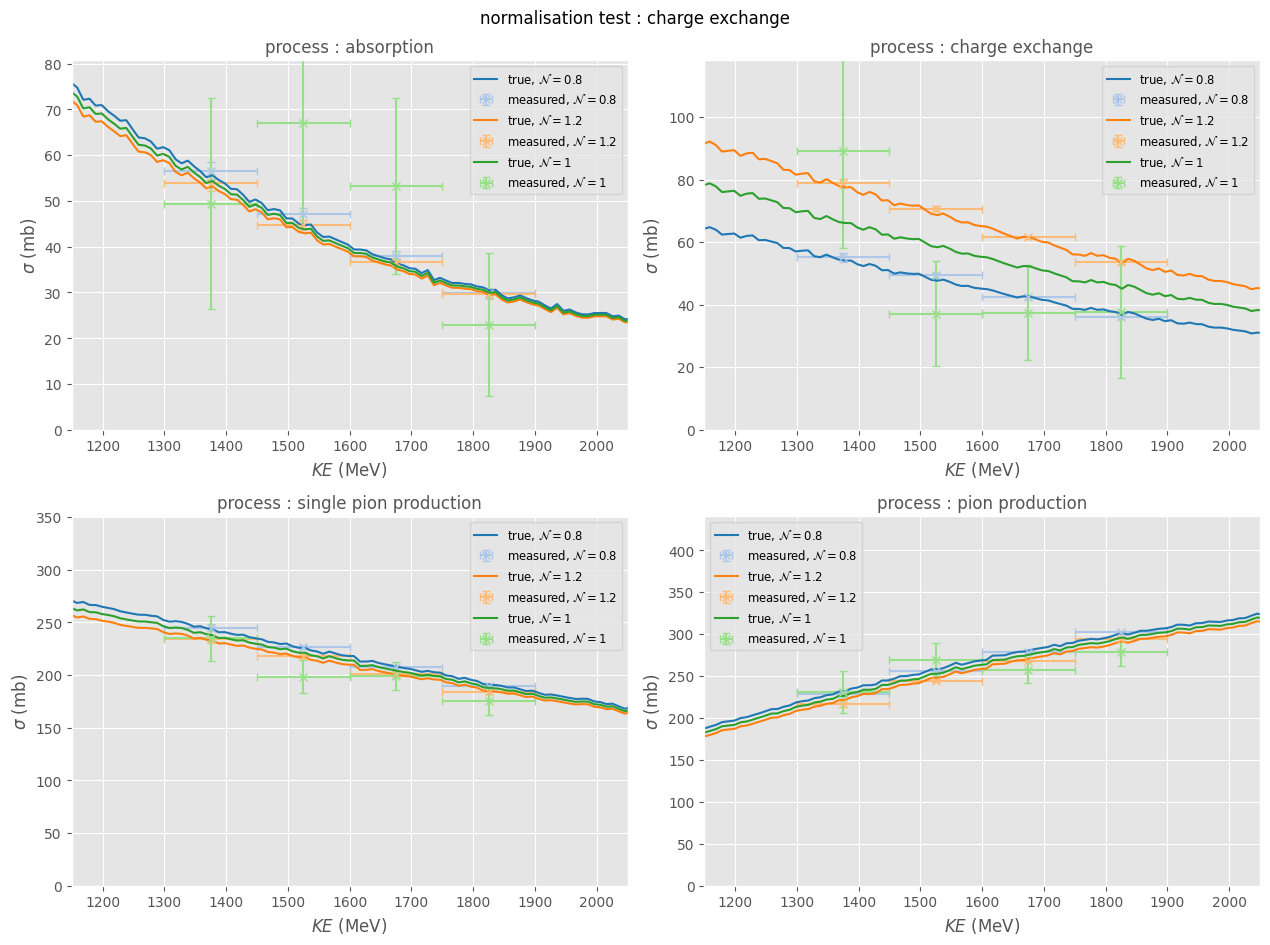

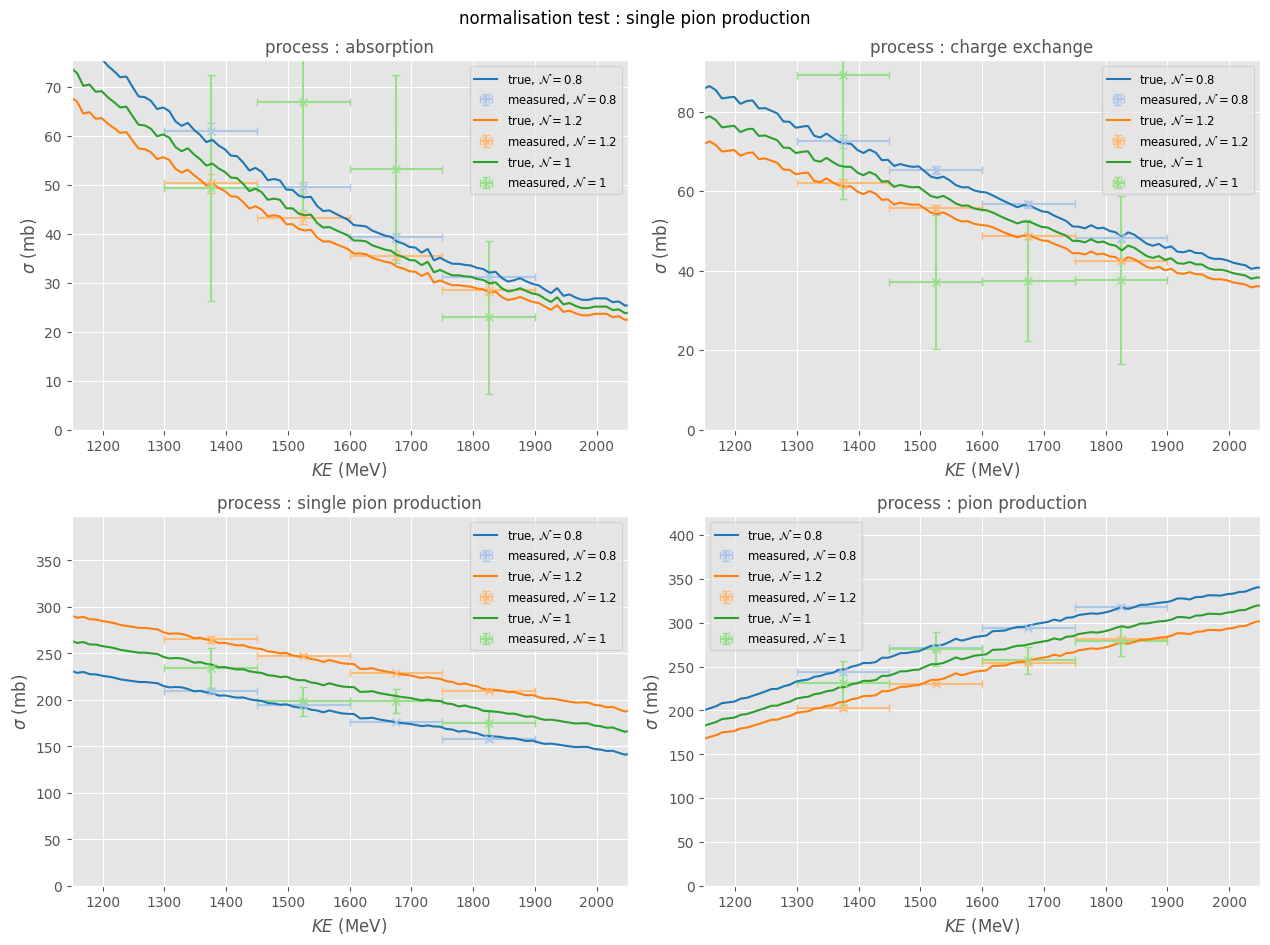

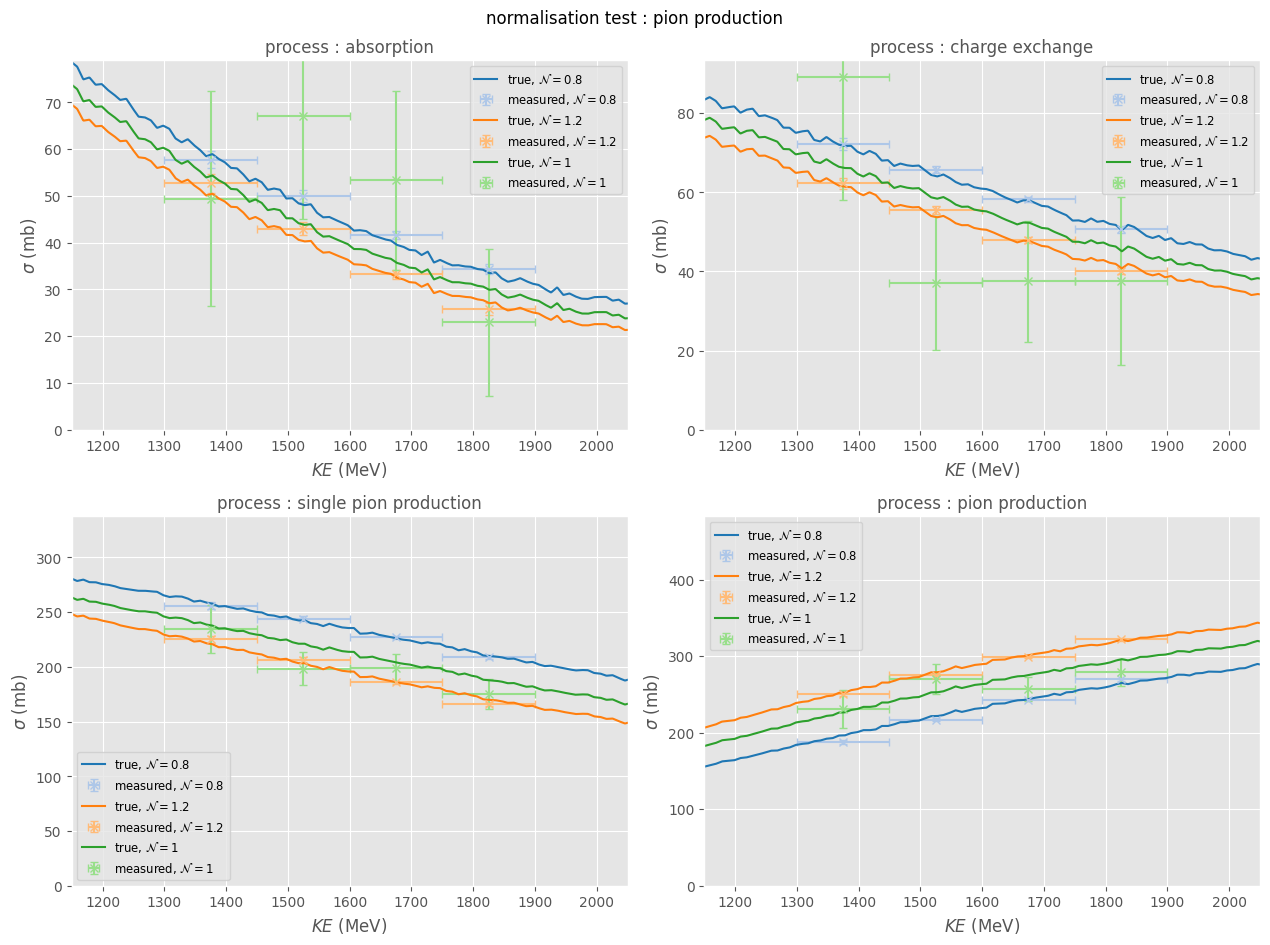

In [13]:
cross_section.SetPlotStyle(dark = False, extend_colors = True, dpi = 100)
cex_systematics.NormalisationSystematic.PlotNormalisationTestResults(results, args, xs_nominal)
cross_section.SetPlotStyle(dark = True, extend_colors = False, dpi = 100)

In [34]:
sys = cross_section.LoadObject("work/2023/beam_selections/new_selection_true/new_bins/systematics/theory/sys.dill")
xs_nominal = cross_section.LoadObject("work/2023/beam_selections/new_selection_true/new_bins/measurement/xs.dill")

In [35]:
print(sys)

{
    'systematic': {
        'low': {
            'absorption': {
                'absorption': array([0.89285509, 1.36760623, 1.94339621, 1.14046186]),
                'charge_exchange': array([0.56391652, 0.22451178, 1.91562594, 0.96512393]),
                'single_pion_production': array([1.62995614, 0.05085201, 1.70788958, 2.38479895]),
                'pion_production': array([0.98477639, 2.26005961, 2.73487287, 2.85712751])
            },
            'charge_exchange': {
                'absorption': array([0.71679023, 1.53752359, 2.33878437, 1.08319658]),
                'charge_exchange': array([0.59498037, 0.17354031, 1.66967722, 0.90262564]),
                'single_pion_production': array([1.72148058, 0.22478535, 0.90847511, 1.43309866]),
                'pion_production': array([1.39650029, 1.94907334, 2.46233702, 2.66687652])
            },
            'single_pion_production': {
                'absorption': array([0.88917344, 0.66550853, 1.97969137, 1.86361223]),
                'charge_exchange': array([0.29752956, 0.26855506, 1.90643109, 0.42497788]),
                'single_pion_production': array([3.16697959, 0.06143275, 2.9220655 , 2.41494857]),
                'pion_production': array([1.08983349, 2.39370864, 2.773557  , 2.22748281])
            },
            'pion_production': {
                'absorption': array([0.88511013, 1.95933808, 1.87858643, 1.03670221]),
                'charge_exchange': array([0.05647377, 0.24787525, 1.65060172, 0.33288374]),
                'single_pion_production': array([1.39005607, 0.91283645, 1.63860241, 2.03068816]),
                'pion_production': array([4.83482114, 1.53332951, 4.70549909, 8.62063879])
            }
        },
        'high': {
            'absorption': {
                'absorption': array([0.06361503, 1.79991557, 2.26897132, 0.64771764]),
                'charge_exchange': array([0.12765677, 0.13157068, 1.640251  , 1.03033609]),
                'single_pion_production': array([1.5327096 , 0.11105877, 0.80384695, 0.23397465]),
                'pion_production': array([2.94797141, 2.19692906, 3.24596696, 5.03450939])
            },
            'charge_exchange': {
                'absorption': array([0.11428428, 1.58310837, 1.74901106, 0.77781858]),
                'charge_exchange': array([0.30410941, 0.11270539, 1.89150104, 1.0555971 ]),
                'single_pion_production': array([1.46664479, 0.18052925, 1.0532426 , 0.88874105]),
                'pion_production': array([2.50118233, 2.35527639, 3.46084202, 5.19559335])
            },
            'single_pion_production': {
                'absorption': array([0.49323186, 2.14255665, 2.42322861, 0.11937271]),
                'charge_exchange': array([0.15069991, 0.18394034, 1.3675238 , 0.67578629]),
                'single_pion_production': array([1.59746278, 0.26781289, 1.09958377, 0.7771328 ]),
                'pion_production': array([3.70189152, 2.26639157, 4.09733105, 6.17507949])
            },
            'pion_production': {
                'absorption': array([1.2864656 , 0.53350373, 2.66308368, 2.29964043]),
                'charge_exchange': array([0.7480893 , 0.24407282, 1.71080181, 0.75230073]),
                'single_pion_production': array([3.54049232, 0.38102136, 3.26717089, 4.06512352]),
                'pion_production': array([0.76666914, 2.73651082, 2.95249505, 1.67692632])
            }
        }
    },
    'fractional': {
        'low': {
            'absorption': {
                'absorption': array([0.03071571, 0.03692493, 0.0433943 , 0.0207889 ]),
                'charge_exchange': array([0.01243516, 0.00433324, 0.03221567, 0.01445682]),
                'single_pion_production': array([0.00869167, 0.00024743, 0.00765048, 0.00996642]),
                'pion_production': array([0.00332999, 0.00830192, 0.01097156, 0.01279533])
            },
            'charge_exchange': {
                'absorption': array([0.02465878, 0.04151265, 0.05222297, 0.01974504]),
        

In [40]:
# import pandas as pd
# sys["fractional"]
print(tables["absorption"])

$KE$ (MeV)     Total Data stat Model inaccuracy abs low  \
0       1375  0.175596   0.17042                 0.020789   
1       1525  0.237437  0.223083                 0.043394   
2       1675  0.225968  0.217202                 0.036925   
3       1825  1.081669  1.081038                 0.030716   
4    average  0.430167  0.422936                 0.032956   

  Model inaccuracy cex low Model inaccuracy spip low Model inaccuracy pip low  \
0                 0.014457                  0.009966                 0.012795   
1                 0.032216                   0.00765                 0.010972   
2                 0.004333                  0.000247                 0.008302   
3                 0.012435                  0.008692                  0.00333   
4                  0.01586                  0.006639                  0.00885   

  Model inaccuracy high Model inaccuracy high Model inaccuracy high  \
0              0.011807              0.015434              0.000978   
1              0.050664              0.027585              0.003601   
2              0.048597              0.002539               0.00054   
3              0.002188              0.002815              0.008173   
4              0.028314              0.012093              0.003323   

  Model inaccuracy high  
0              0.022547  
1              0.013022  
2               0.00807  
3              0.009968  
4              0.013402

In [34]:
book = Plots.PlotBook("normalisation_sys.pdf", False)

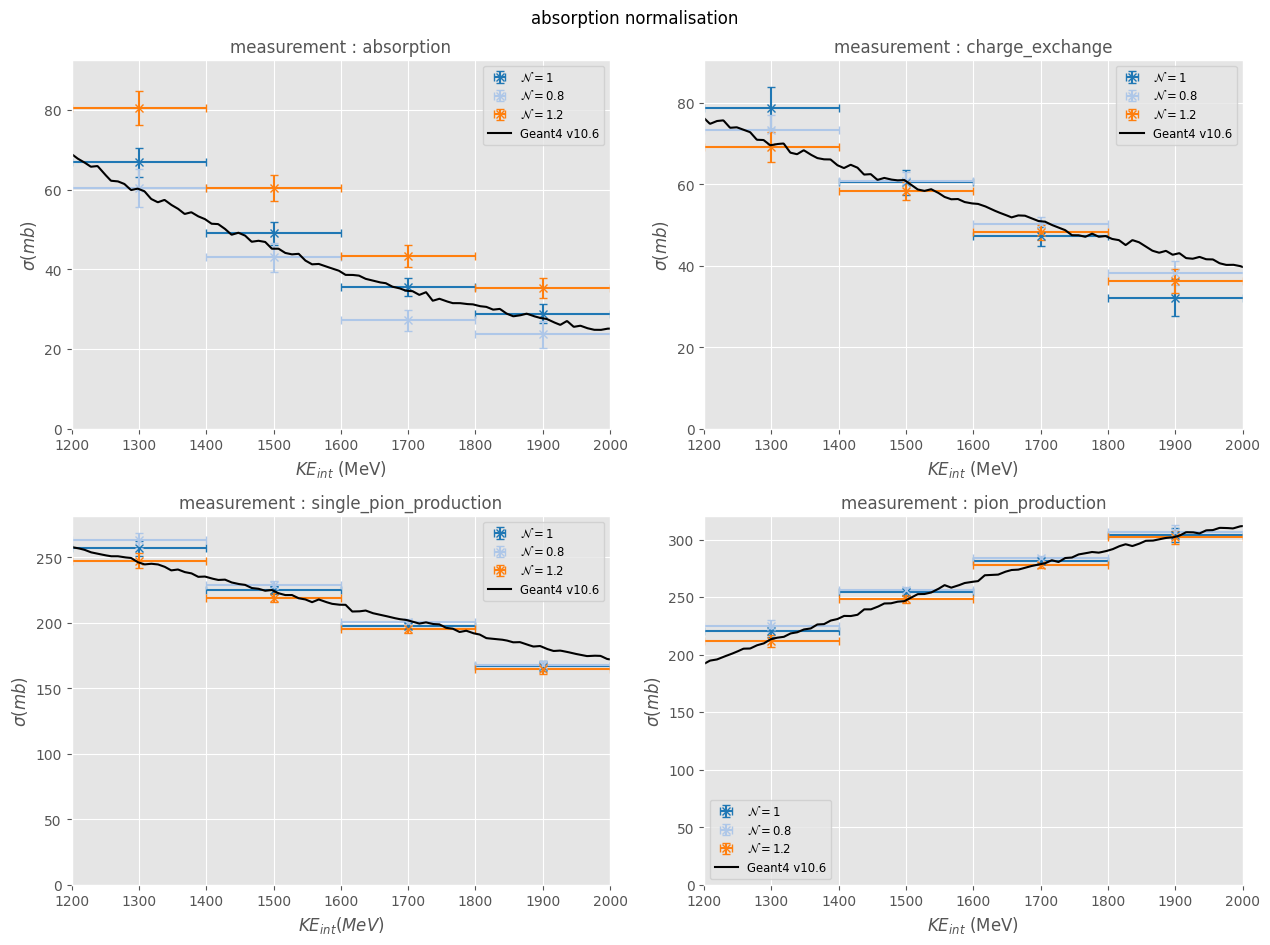

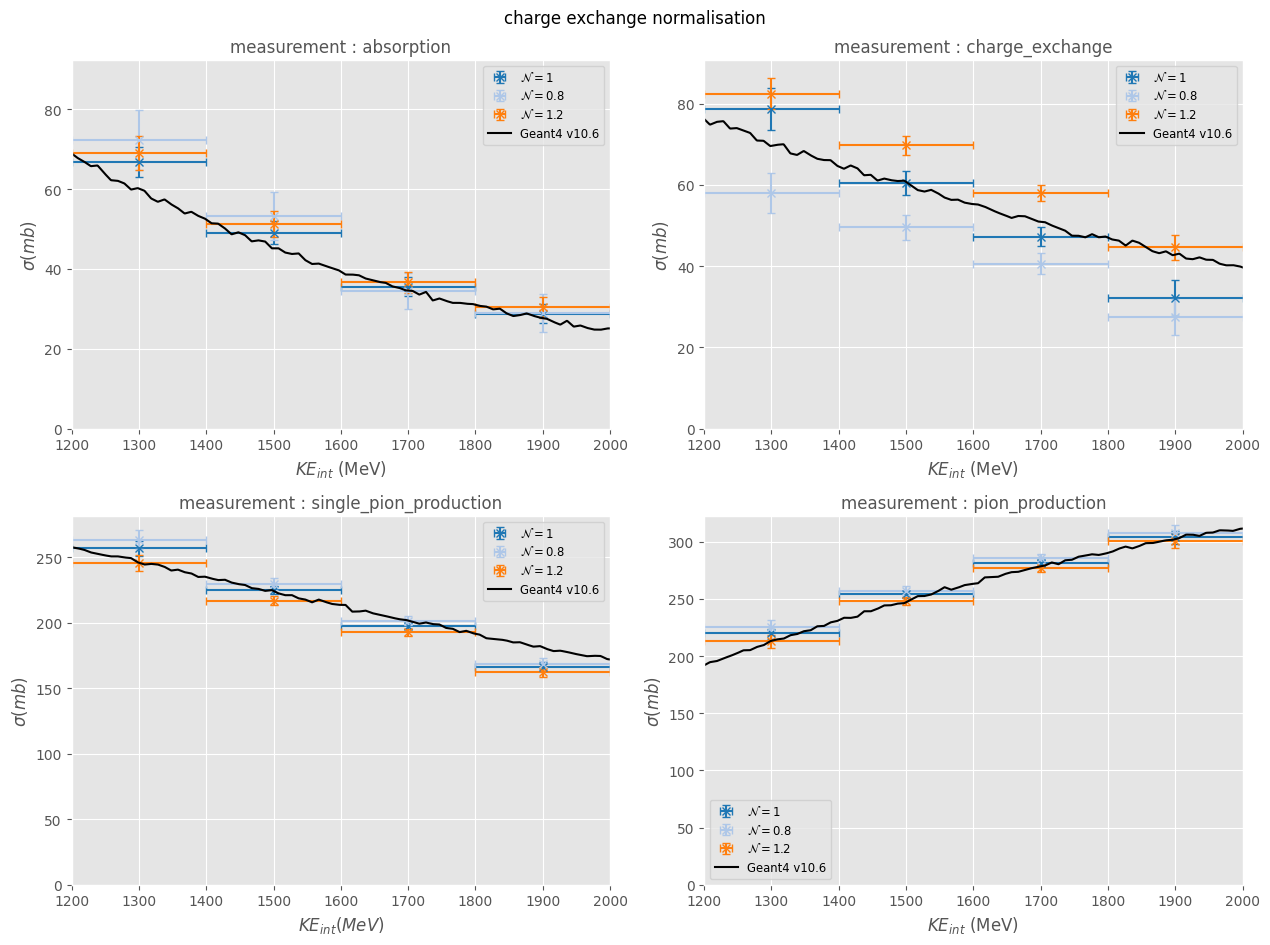

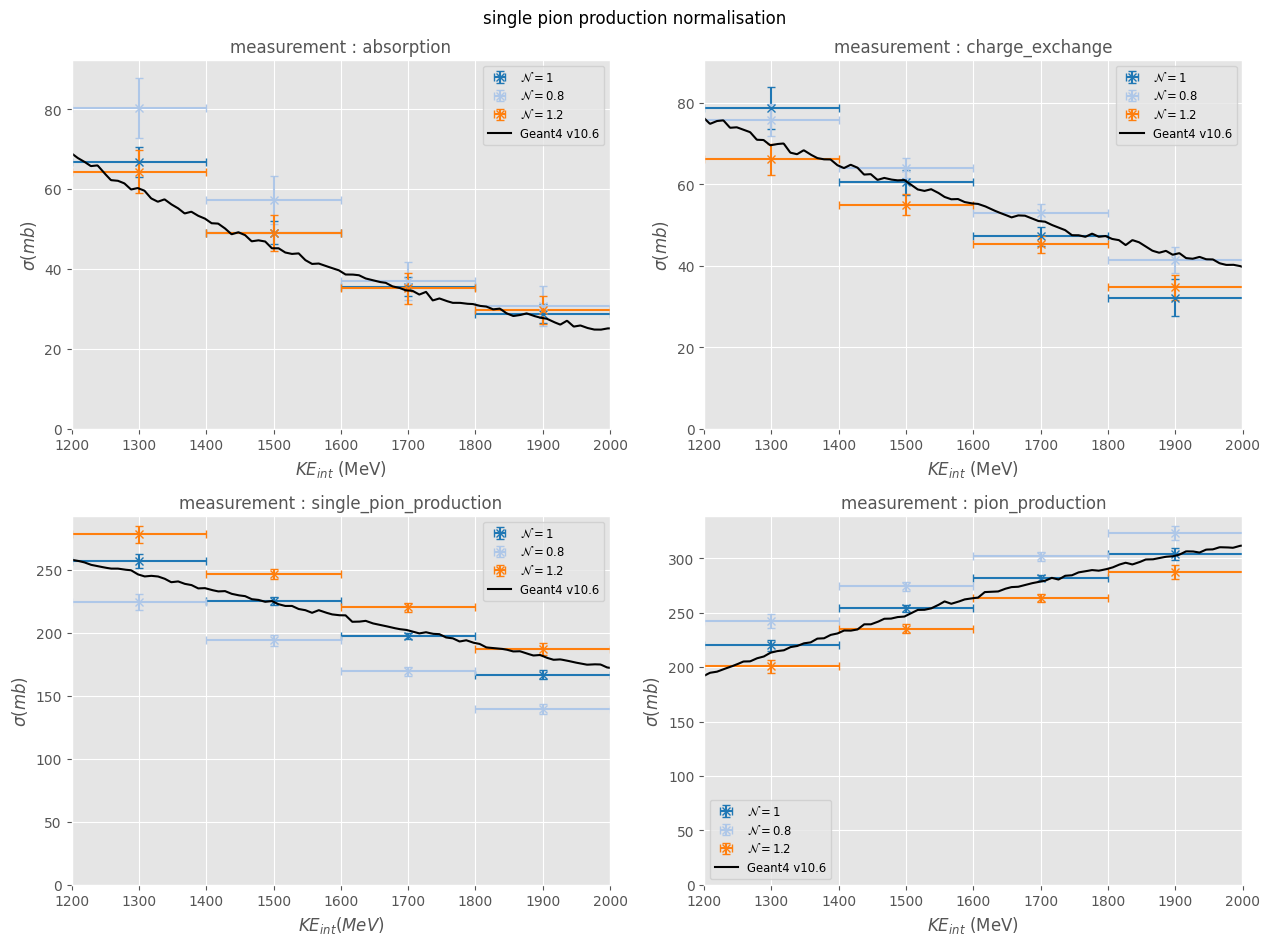

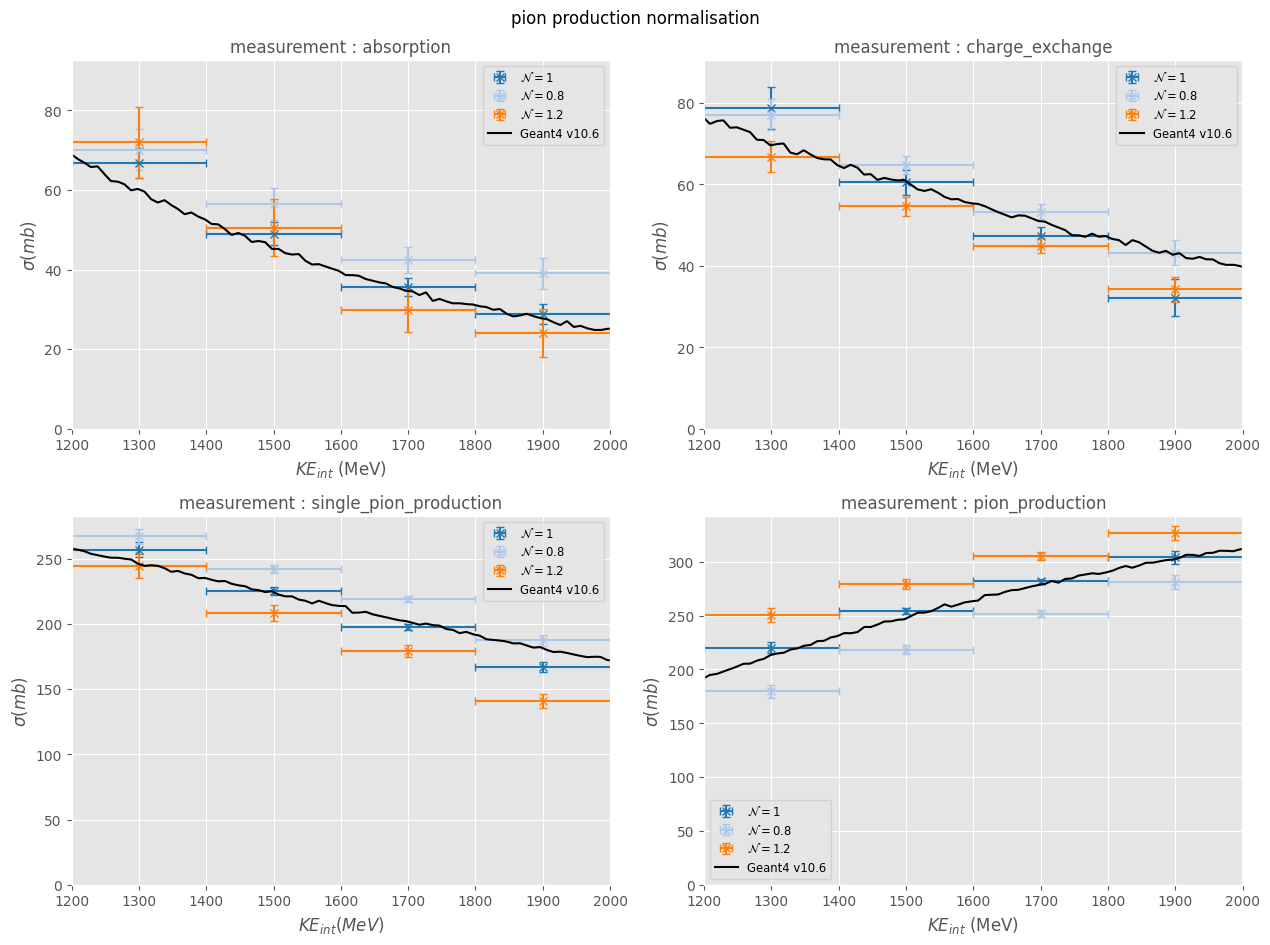

In [35]:
xs_sim = cross_section.GeantCrossSections()

for r in results[0]:
    for _, p in Plots.IterMultiPlot(analysis_input_nominal.exclusive_process):
        cross_section.PlotXSComparison({"$\mathcal{N}=1$" : xs_nominal[p], "$\mathcal{N}=0.8$" : results[0][r][0.8][p], "$\mathcal{N}=1.2$" : results[0][r][1.2][p]}, args.energy_slices, p, title = f"measurement : {p}", newFigure = False, chi2 = False, simulation_label = "Geant4 v10.6")
        
        if p == "single_pion_production":
            gxs = getattr(xs_sim, "double_charge_exchange") + getattr(xs_sim, "quasielastic")
        else:
            gxs = getattr(xs_sim, p)

        # Plots.plt.fill_between(xs_sim.KE, gxs * 0.8, gxs * 1.2, color = "k", alpha = 0.5, label = "theory uncertainty ($\pm20\%$)", zorder = 1)
        Plots.plt.legend()
    Plots.plt.suptitle(f"{cross_section.remove_(r)} normalisation")
    Plots.plt.tight_layout()
    book.Save()

In [9]:
sys_err = cex_systematics.NormalisationSystematic.CalculateSysErr(results)

In [131]:
norm_sys_qs = cex_systematics.NormalisationSystematic.TotalSysQS(sys_err)

norm_sys_max = cex_systematics.NormalisationSystematic.TotalSysMax(sys_err)

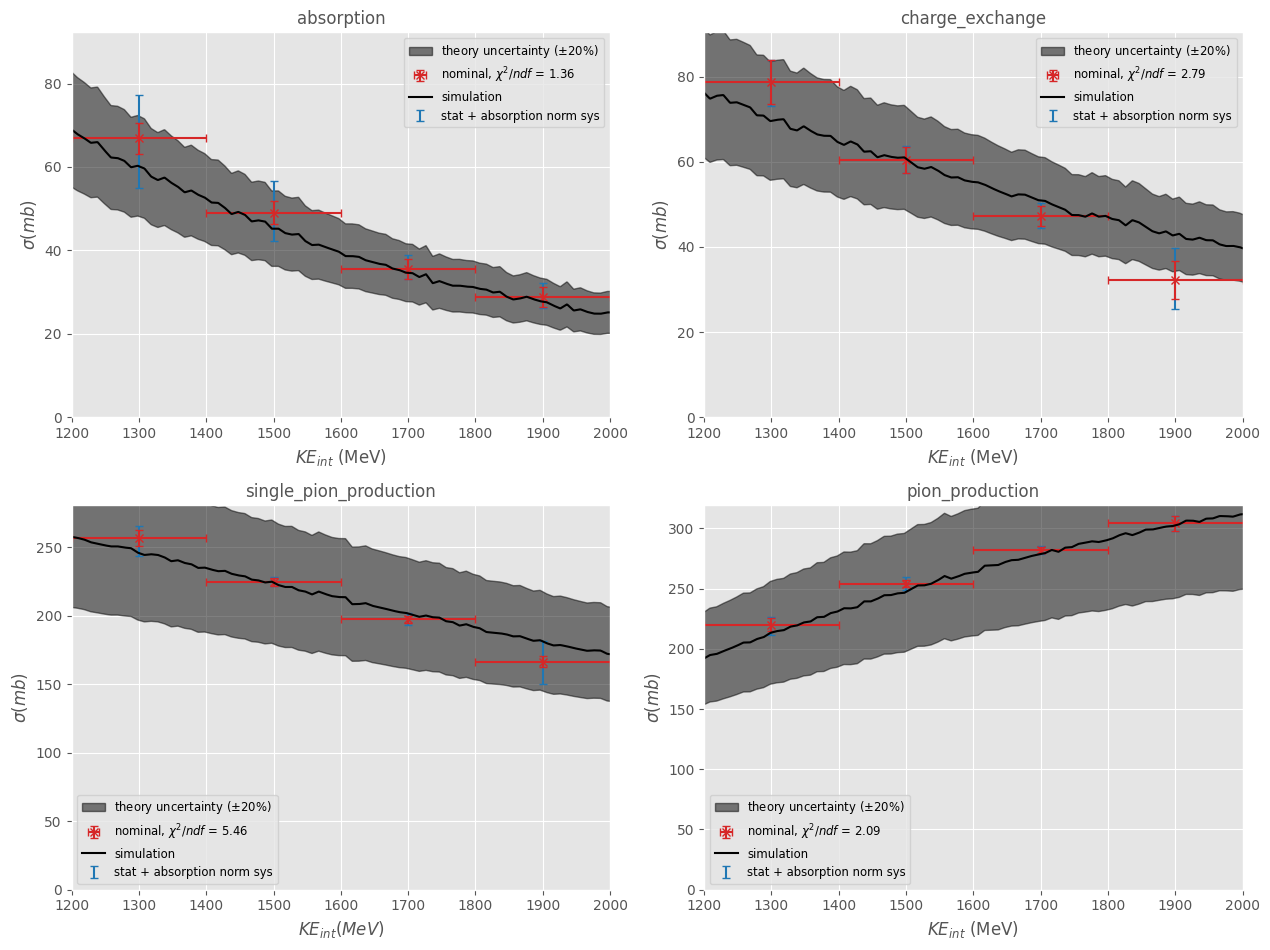

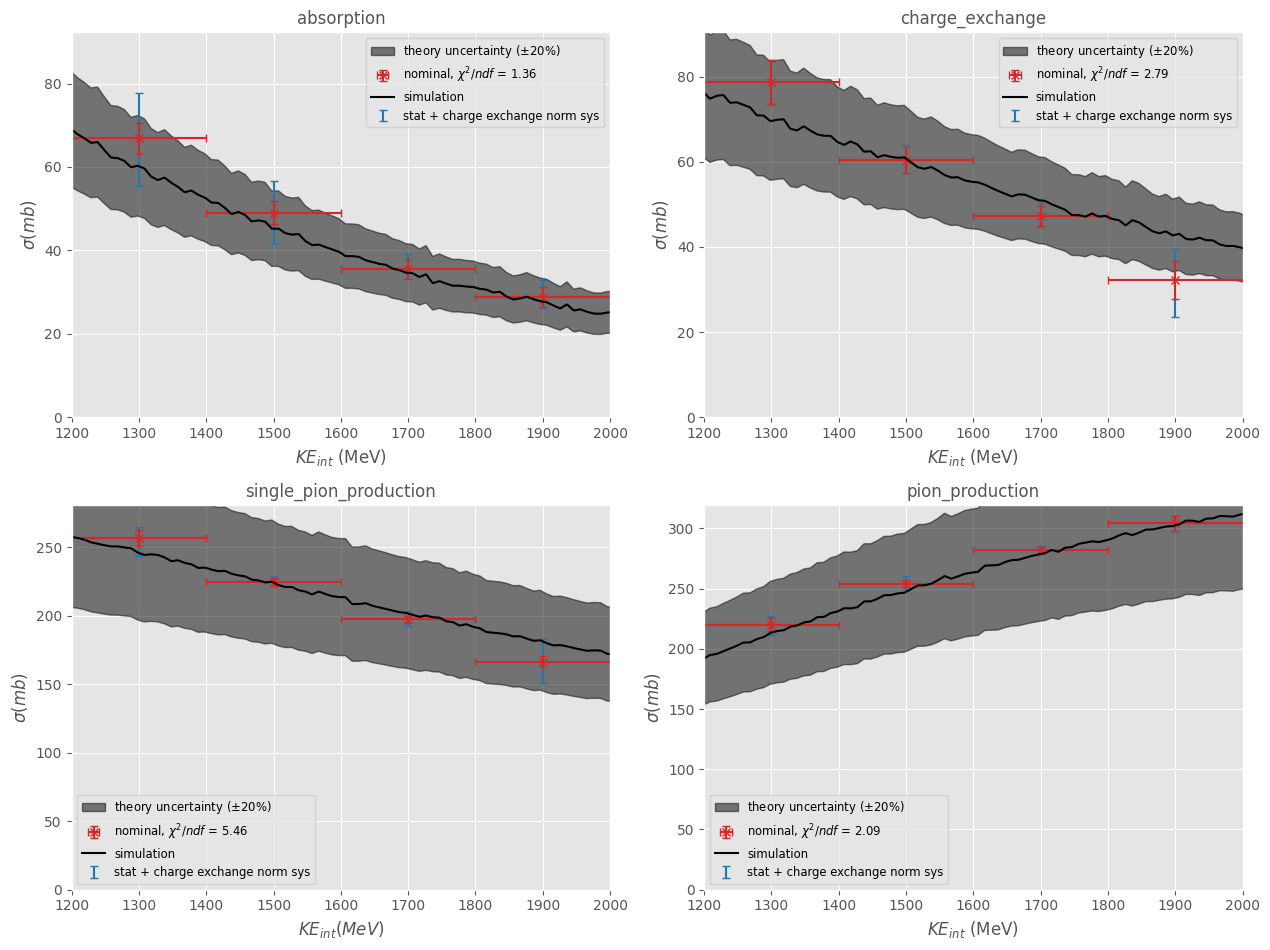

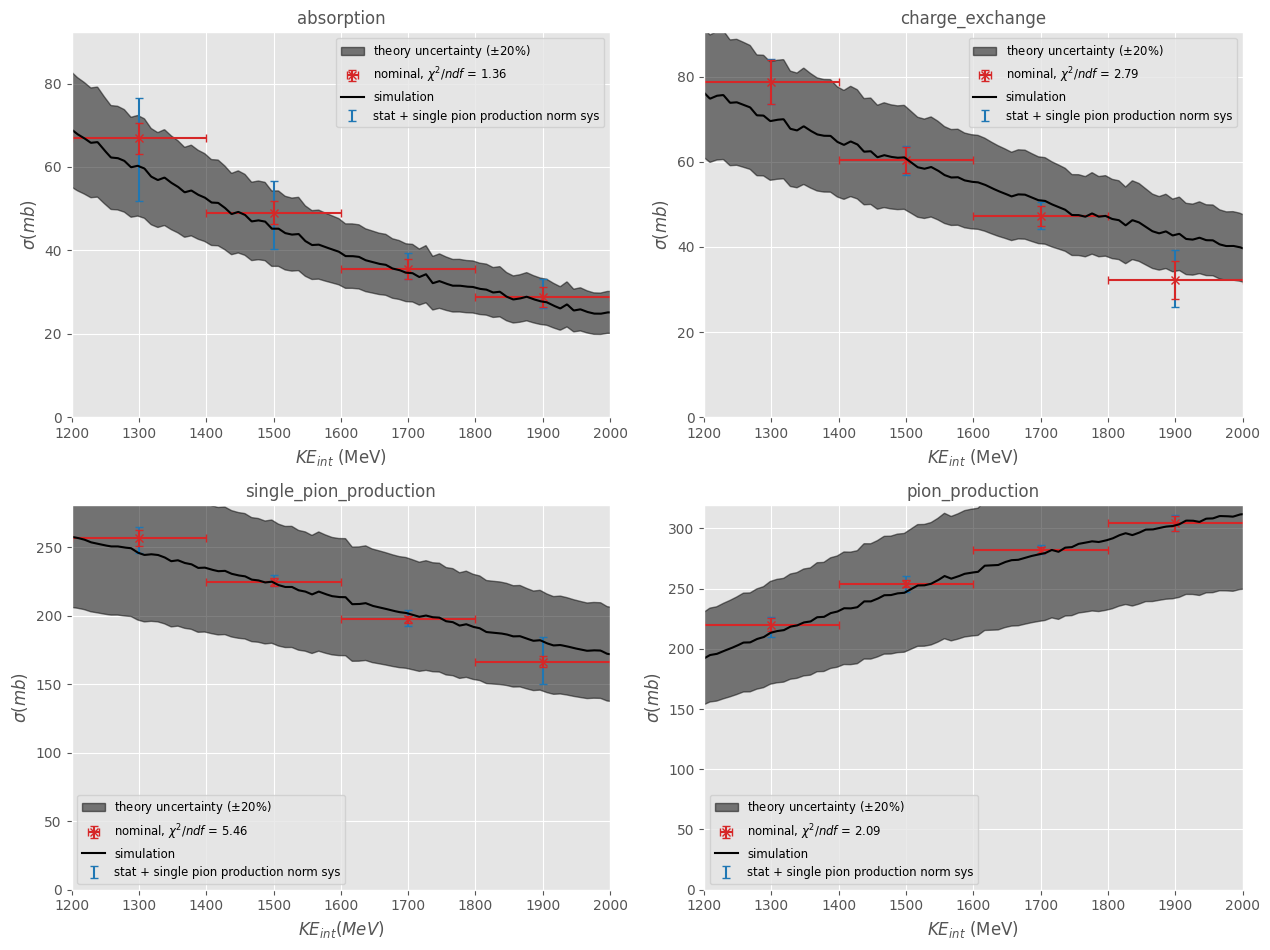

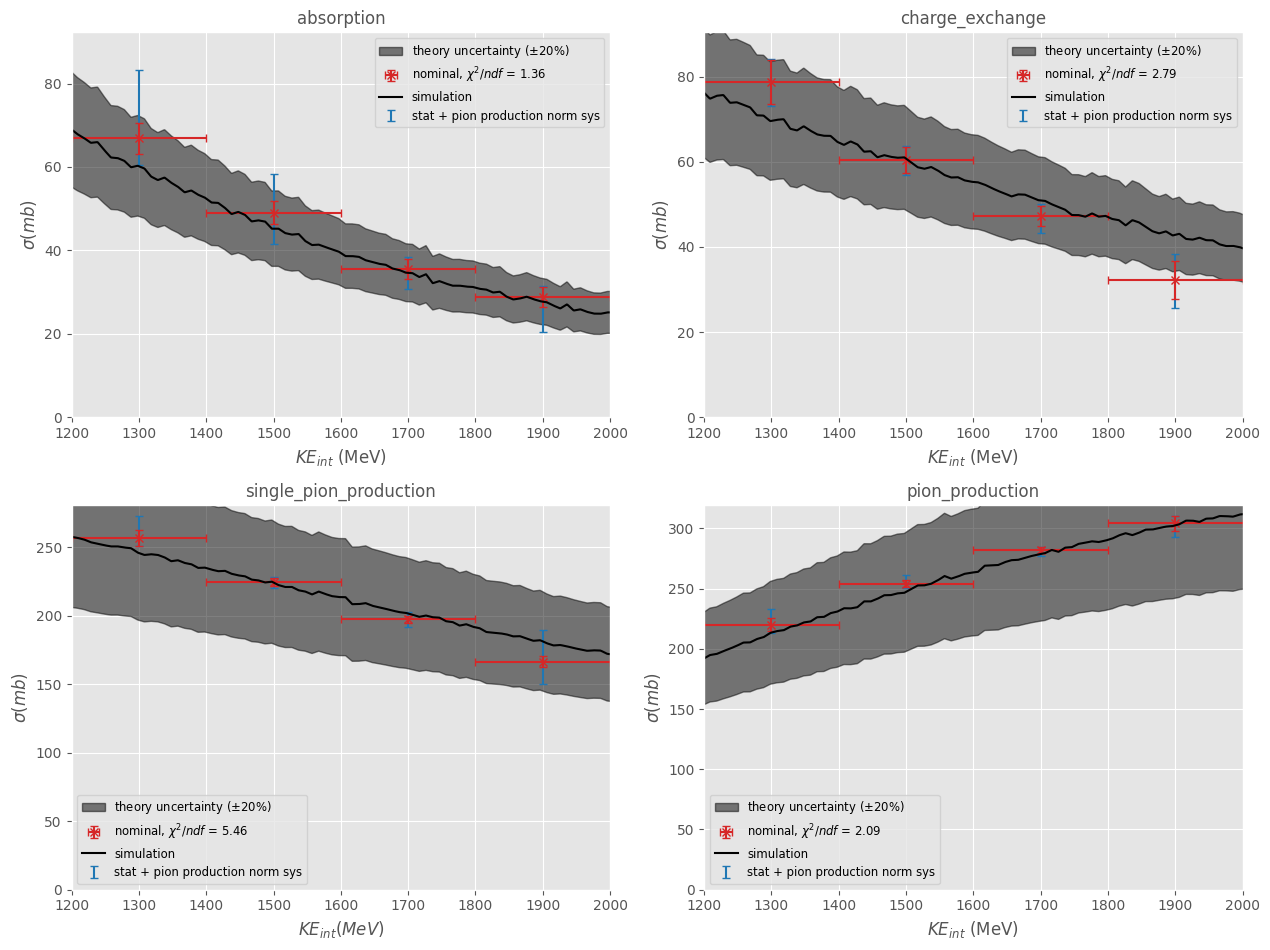

In [38]:
for r in results[0]:    
    for _, p in Plots.IterMultiPlot(analysis_input_nominal.exclusive_process):
        total_err_low = cross_section.quadsum([xs_nominal[p][1], sys_err["low"][r][p]], 0)
        total_err_high = cross_section.quadsum([xs_nominal[p][1], sys_err["high"][r][p]], 0)

        cross_section.PlotXSComparison({"nominal" : xs_nominal[p]}, args.energy_slices, p, {"nominal" : "C6"}, xs_sim_color = "k", title = p, newFigure = False)
        x = args.energy_slices.pos[:-1] - args.energy_slices.width/2
        Plots.Plot(x, xs_nominal[p][0], yerr = [total_err_low, total_err_high], linestyle = "", marker = "", label = f"stat + {cross_section.remove_(r)} norm sys", newFigure = False, zorder = 1.5)

        if p == "single_pion_production":
            gxs = getattr(xs_sim, "double_charge_exchange") + getattr(xs_sim, "quasielastic")
        else:
            gxs = getattr(xs_sim, p)

        Plots.plt.fill_between(xs_sim.KE, gxs * 0.8, gxs * 1.2, color = "k", alpha = 0.5, label = "theory uncertainty ($\pm20\%$)", zorder = 1)
        Plots.plt.legend()
        book.Save()


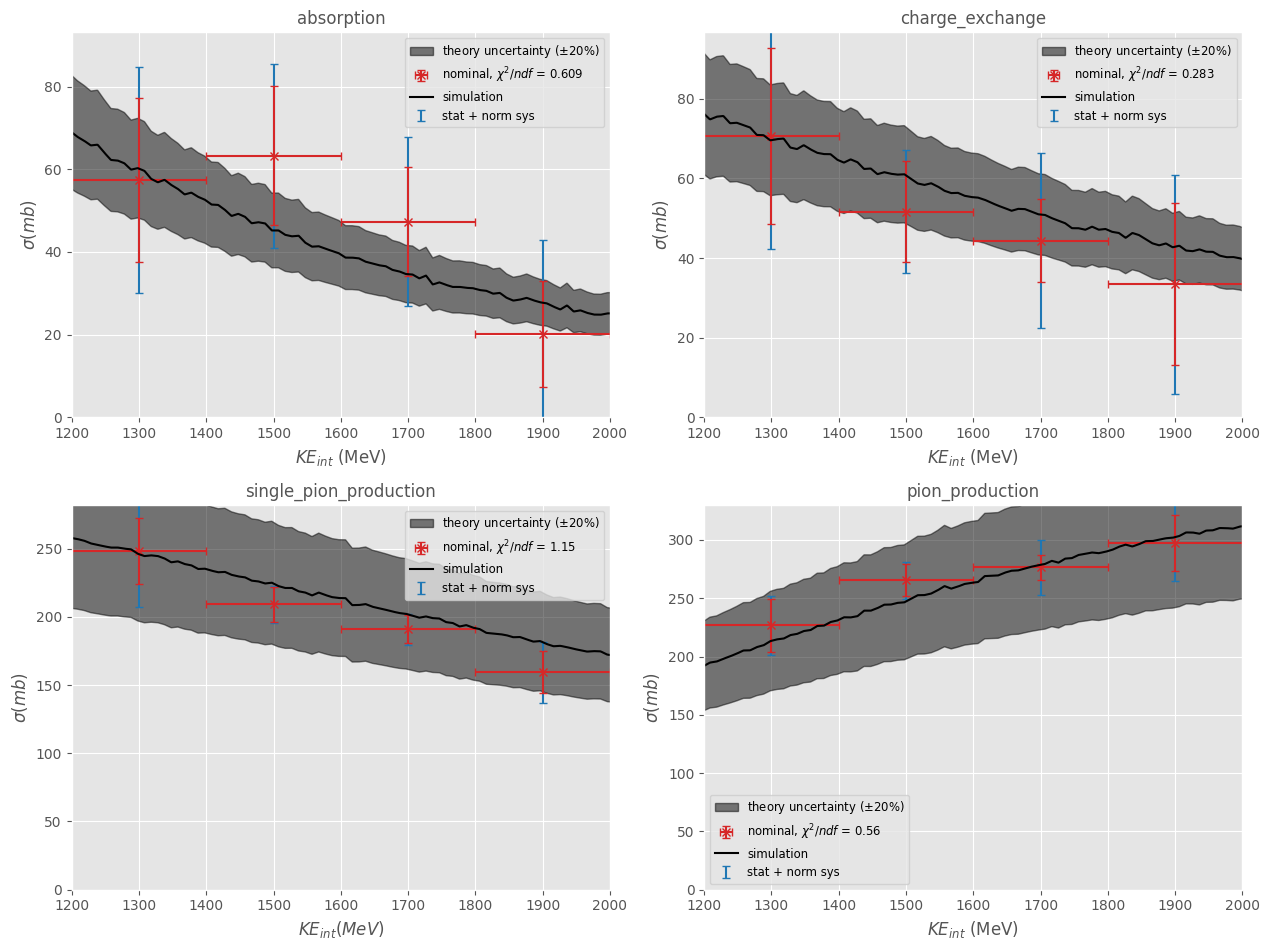

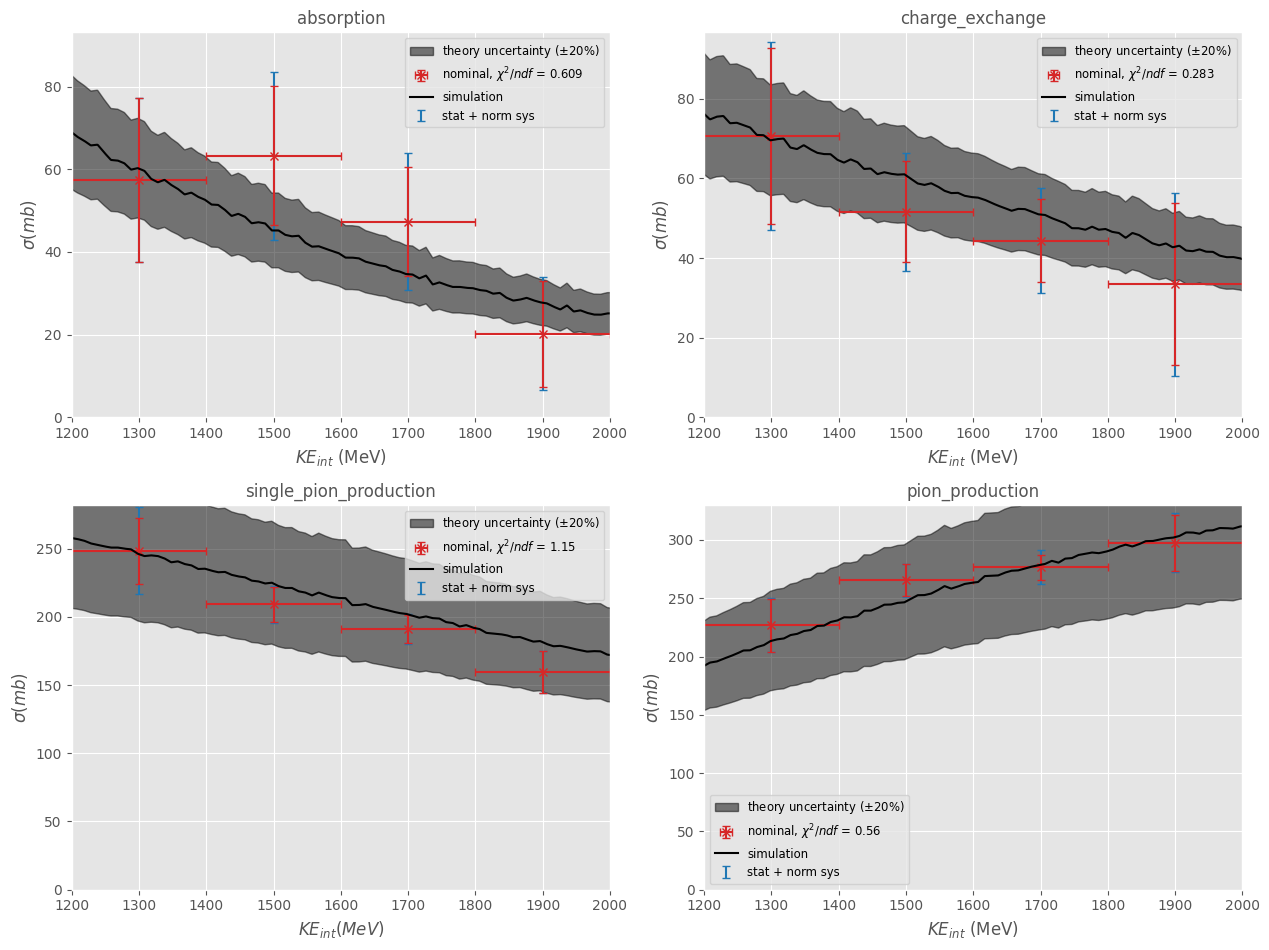

In [132]:
xs_sim = cross_section.GeantCrossSections()
for _, p in Plots.IterMultiPlot(norm_sys_qs):
    total_err = [cross_section.quadsum([xs_nominal[p][1], norm_sys_qs[p][0]], 0) for i in range(2)]

    x = args.energy_slices.pos[:-1] - args.energy_slices.width/2

    cross_section.PlotXSComparison({"nominal" : xs_nominal[p]}, args.energy_slices, p, {"nominal" : "C6"}, xs_sim_color = "k", title = p, newFigure = False)
    Plots.Plot(x, xs_nominal[p][0], yerr = total_err, linestyle = "", marker = "", label = f"stat + norm sys", newFigure = False, zorder = 1.5)

    if p == "single_pion_production":
        gxs = getattr(xs_sim, "double_charge_exchange") + getattr(xs_sim, "quasielastic")
    else:
        gxs = getattr(xs_sim, p)

    Plots.plt.fill_between(xs_sim.KE, gxs * 0.8, gxs * 1.2, color = "k", alpha = 0.5, label = "theory uncertainty ($\pm20\%$)", zorder = 1)
    Plots.plt.legend()
    book.Save()

for _, p in Plots.IterMultiPlot(norm_sys_max):
    total_err = [cross_section.quadsum([xs_nominal[p][1], norm_sys_max[p][0]], 0) for i in range(2)]

    cross_section.PlotXSComparison({"nominal" : xs_nominal[p]}, args.energy_slices, p, {"nominal" : "C6"}, xs_sim_color = "k", title = p, newFigure = False)
    Plots.Plot(x, xs_nominal[p][0], yerr = total_err, linestyle = "", marker = "", label = f"stat + norm sys", newFigure = False, zorder = 1.5)

    if p == "single_pion_production":
        gxs = getattr(xs_sim, "double_charge_exchange") + getattr(xs_sim, "quasielastic")
    else:
        gxs = getattr(xs_sim, p)

    Plots.plt.fill_between(xs_sim.KE, gxs * 0.8, gxs * 1.2, color = "k", alpha = 0.5, label = "theory uncertainty ($\pm20\%$)", zorder = 1)
    Plots.plt.legend()
    book.Save()

# norm_sys = []
# for r in results[0]:
#     err_low = SysErr(results[1][r][1.2], results[0][r][1.2][0])
#     err_high = SysErr(results[1][r][0.8], results[0][r][0.8][0])

#     sys_err_low = np.max([err_low[0], err_high[0]], 0)
#     sys_err_high = np.max([err_low[1], err_high[1]], 0)

#     norm_sys.append([sys_err_low, sys_err_high])

# total_norm_sys = cross_section.quadsum(norm_sys, 0)
# total_sys = [cross_section.quadsum([xs_nominal[1], total_norm_sys[0]], 0), cross_section.quadsum([xs_nominal[1], total_norm_sys[1]], 0)]

# cross_section.PlotXSComparison({"nominal" : xs_nominal}, args.energy_slices, "charge_exchange", {"nominal" : "C6"}, xs_sim_color = "k")
# Plots.Plot(args.energy_slices.pos - args.energy_slices.width/2, xs_nominal[0], yerr = total_sys, linestyle = "", marker = "", label = f"stat + sys", newFigure = False, zorder = 1.5)
# Plots.plt.fill_between(xs_sim.KE, getattr(xs_sim, args.signal_process) * 0.8, getattr(xs_sim, args.signal_process) * 1.2, color = "k", alpha = 0.5, label = "theory uncertainty ($\pm20\%$)", zorder = 1)
# Plots.plt.legend()

# book.Save()

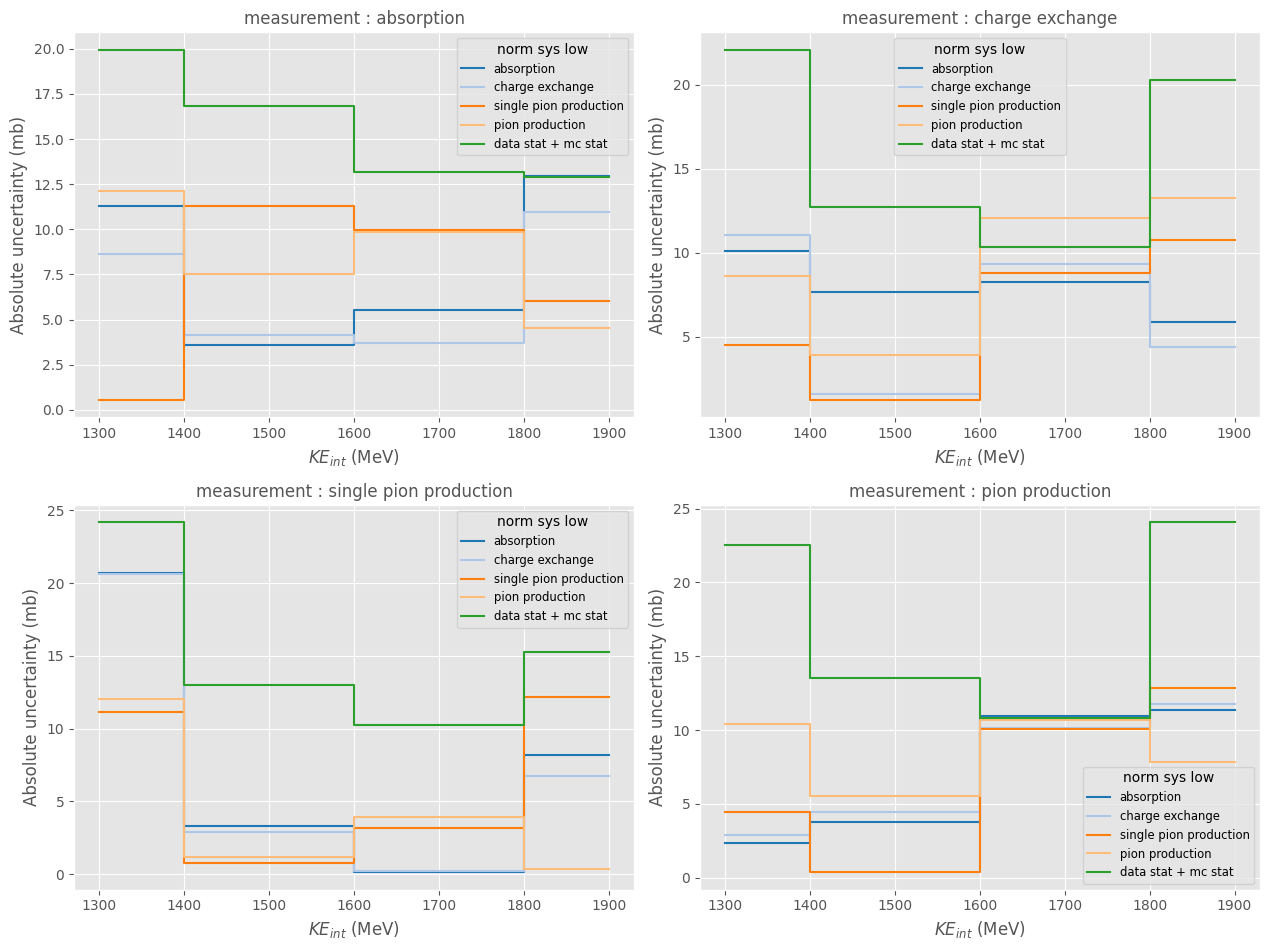

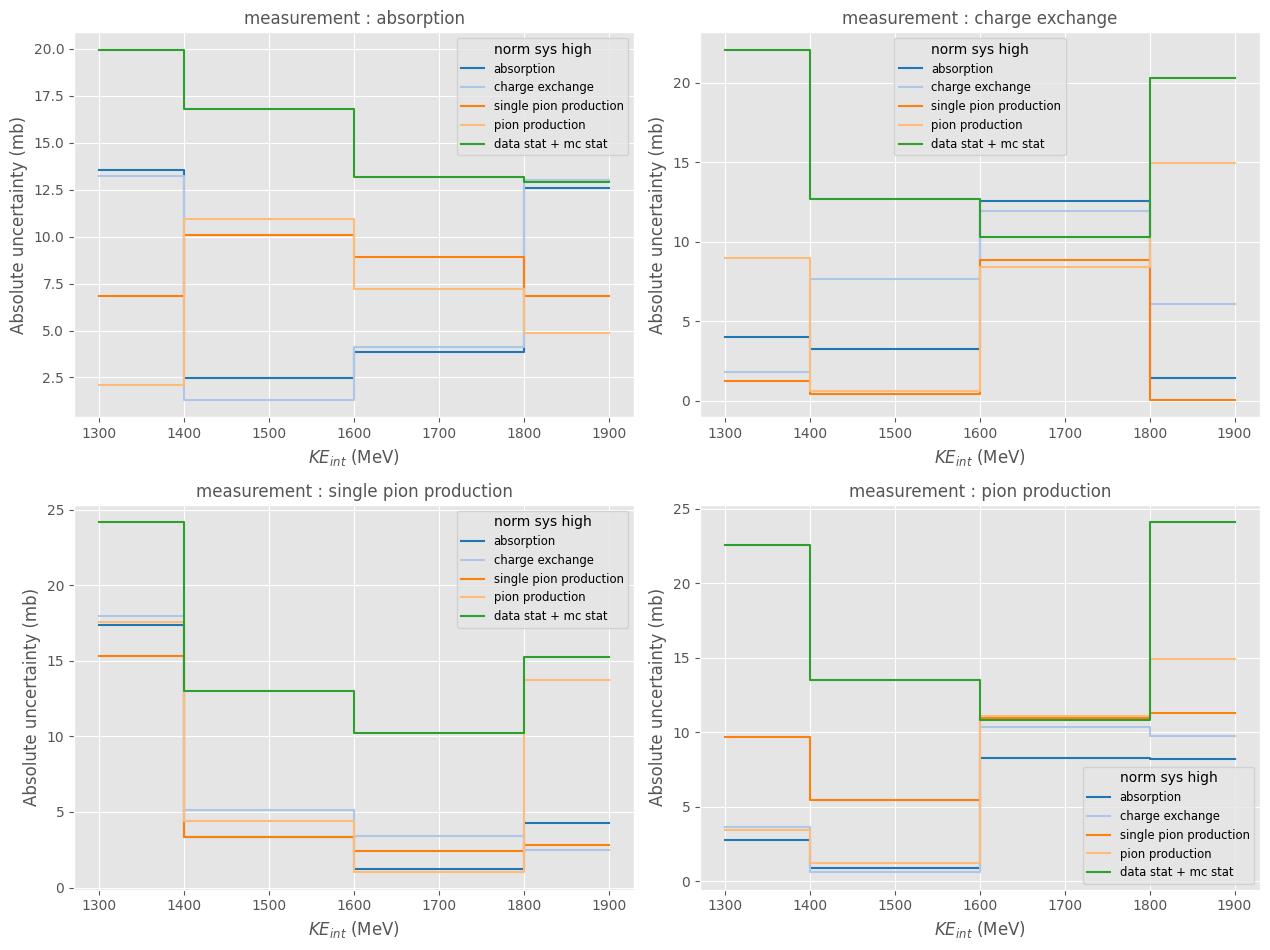

In [133]:
def PlotSys(sys, name : str):
    x = args.energy_slices.pos[:-1] - args.energy_slices.width/2

    for _, p in Plots.IterMultiPlot(analysis_input_nominal.exclusive_process):
        for r in sys:
            Plots.Plot(x, abs(sys[r][p]), label = cross_section.remove_(r), title = f"measurement : {cross_section.remove_(p)}", xlabel = "$KE_{int}$ (MeV)", ylabel = "Absolute uncertainty (mb)", newFigure = False, style = "step")
        Plots.Plot(x, xs_nominal[p][1], label = "data stat + mc stat", newFigure = False, style = "step")
        Plots.plt.legend(title = name)

PlotSys(sys_err["low"], "norm sys low")
PlotSys(sys_err["high"], "norm sys high")

In [27]:
book.close()

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:890: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


# Data analysis systematics

In [40]:
args_low = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration("work/2023/beam_selections/new_selection_true/analysis_config.json"))

In [8]:
upl = cex_systematics.UpstreamCorrectionSystematic(args_low)
# upl.CreateNewAIs("test/")

In [117]:
ai_low = cross_section.AnalysisInput.FromFile("test/upstream_loss_1_sigma_low/analysis_input/analysis_input_mc_selected.dill")
ai_high = cross_section.AnalysisInput.FromFile("test/upstream_loss_1_sigma_high/analysis_input/analysis_input_mc_selected.dill")
ai_nominal = cross_section.AnalysisInput.FromFile("work/2023/beam_selections/new_selection_true/analysis_input/analysis_input_mc_selected.dill")

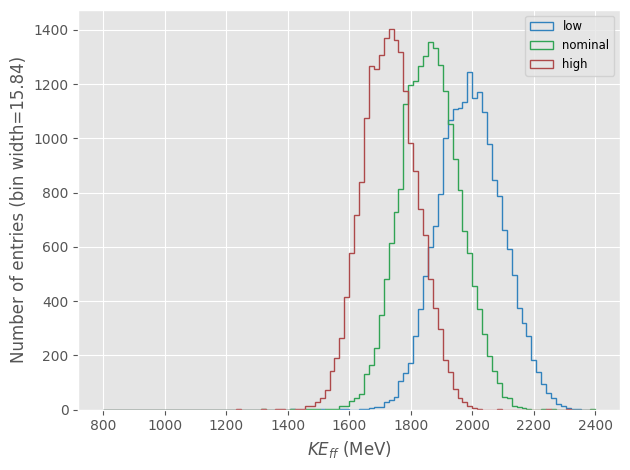

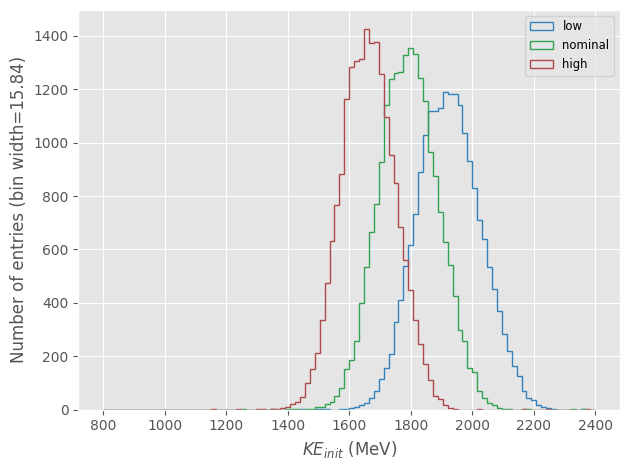

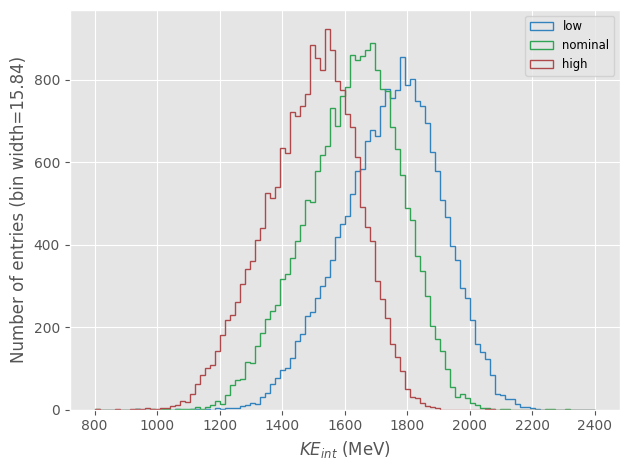

In [124]:
Plots.PlotHistComparison([ai_low.KE_ff_reco, ai_nominal.KE_ff_reco, ai_high.KE_ff_reco], labels = ["low", "nominal", "high"], density = False, x_range = [800, 2400], xlabel = "$KE_{ff}$ (MeV)")
Plots.PlotHistComparison([ai_low.KE_init_reco, ai_nominal.KE_init_reco, ai_high.KE_init_reco], labels = ["low", "nominal", "high"], density = False, x_range = [800, 2400], xlabel = "$KE_{init}$ (MeV)")
Plots.PlotHistComparison([ai_low.KE_int_reco, ai_nominal.KE_int_reco, ai_high.KE_int_reco], labels = ["low", "nominal", "high"], density = False, x_range = [800, 2400], xlabel = "$KE_{int}$ (MeV)")

In [33]:
result = upl.RunAnalysis("work/2023/beam_selections/new_selection_true/systematics/upstream/")

loading Data and MC

analysing pdsp

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:890: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']
     nbins: {'channel_0': 1, 'channel_1': 1, 'channel_2': 1, 'channel_3': 1}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('channel_0_stat_err', 'staterror'), ('channel_1_stat_err', 'staterror'), ('channel_2_stat_err', 'staterror'), ('channel_3_stat_err', 'staterror'), ('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['channel_0_stat_err', 'channel_1_stat_err', 'channel_2_stat_err', 'channel_3_stat_err', 'mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 4
   auxdata: [1.0, 1.0, 1.0, 1.0]
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-13920.31485662])


fit_values.bestfit=array([2.53623084, 2.8329717 , 1.83327712, 3.25205647, 0.99998718,
       0.99996485, 1.00000623, 1.00001671])

init
Iteration 1: ts = 0.0152, ts_stopping = 0.0001
Iteration 2: ts = 0.0110, ts_stopping = 0.0001
Iteration 3: ts = 0.0085, ts_stopping = 0.0001
Iteration 4: ts = 0.0069, ts_stopping = 0.0001
Iteration 5: ts = 0.0058, ts_stopping = 0.0001
Iteration 6: ts = 0.0050, ts_stopping = 0.0001
int
Iteration 1: ts = 0.0155, ts_stopping = 0.0001
Iteration 2: ts = 0.0103, ts_stopping = 0.0001
Iteration 3: ts = 0.0072, ts_stopping = 0.0001
Iteration 4: ts = 0.0053, ts_stopping = 0.0001
Iteration 5: ts = 0.0041, ts_stopping = 0.0001
Iteration 6: ts = 0.0033, ts_stopping = 0.0001
absorption
Iteration 1: ts = 0.0515, ts_stopping = 0.0001
Iteration 2: ts = 0.0223, ts_stopping = 0.0001
Iteration 3: ts = 0.0116, ts_stopping = 0.0001
Iteration 4: ts = 0.0061, ts_stopping = 0.0001
Iteration 5: ts = 0.0034, ts_stopping = 0.0001
Iteration 6: ts = 0.0021, ts_stopping = 0.0001
charge_exchange
Iteration 1: ts = 0.0363, ts_stopping = 0.0001
Iteration 2: ts = 0.0163, ts_stopping = 0.0001
Iteration 3: ts = 0.0070

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:1812: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  Plots.plt.figure()
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:994: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:890: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


process={'absorption': (array([ 8.36450473, 28.84554247, 55.69255365, 83.92314083]), array([ 7.12923806, 
11.34992313, 18.13552463, 35.26135329])), 'charge_exchange': (array([ 29.44105934,  35.35813875,  79.98829537, 
107.58915088]), array([11.88156824,  8.41866675, 16.0421238 , 40.88363785])), 'single_pion_production': (array([ 
53.29735688, 100.76937144, 187.78603845, 189.72696272]), array([22.59053305, 15.09359964, 30.60337462, 
68.46283942])), 'pion_production': (array([267.72974369, 313.43053039, 281.19567104, 254.02296268]), 
array([64.55245154, 25.2712089 , 36.35750802, 88.65606708]))}

loading Data and MC

analysing pdsp

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']
     nbins: {'channel_0': 1, 'channel_1': 1, 'channel_2': 1, 'channel_3': 1}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('channel_0_stat_err', 'staterror'), ('channel_1_stat_err', 'staterror'), ('channel_2_stat_err', 'staterror'), ('channel_3_stat_err', 'staterror'), ('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['channel_0_stat_err', 'channel_1_stat_err', 'channel_2_stat_err', 'channel_3_stat_err', 'mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 4
   auxdata: [1.0, 1.0, 1.0, 1.0]
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-13920.31485662])


fit_values.bestfit=array([2.53623095, 2.83297167, 1.83327707, 3.2520565 , 0.99998718,
       0.99996485, 1.00000623, 1.00001671])

init
Iteration 1: ts = 0.0183, ts_stopping = 0.0001
Iteration 2: ts = 0.0146, ts_stopping = 0.0001
Iteration 3: ts = 0.0115, ts_stopping = 0.0001
Iteration 4: ts = 0.0092, ts_stopping = 0.0001
Iteration 5: ts = 0.0077, ts_stopping = 0.0001
Iteration 6: ts = 0.0066, ts_stopping = 0.0001
int
Iteration 1: ts = 0.0142, ts_stopping = 0.0001
Iteration 2: ts = 0.0109, ts_stopping = 0.0001
Iteration 3: ts = 0.0085, ts_stopping = 0.0001
Iteration 4: ts = 0.0068, ts_stopping = 0.0001
Iteration 5: ts = 0.0057, ts_stopping = 0.0001
Iteration 6: ts = 0.0049, ts_stopping = 0.0001
absorption
Iteration 1: ts = 0.0715, ts_stopping = 0.0001
Iteration 2: ts = 0.0335, ts_stopping = 0.0001
Iteration 3: ts = 0.0163, ts_stopping = 0.0001
Iteration 4: ts = 0.0081, ts_stopping = 0.0001
Iteration 5: ts = 0.0041, ts_stopping = 0.0001
Iteration 6: ts = 0.0024, ts_stopping = 0.0001
charge_exchange
Iteration 1: ts = 0.0418, ts_stopping = 0.0001
Iteration 2: ts = 0.0223, ts_stopping = 0.0001
Iteration 3: ts = 0.0130

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:1812: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  Plots.plt.figure()
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:994: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:890: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


process={'absorption': (array([1.36255820e-02, 3.37877097e+01, 5.42309333e+01, 8.94633730e+01]), array([ 
0.24185355, 13.43603694, 12.49182596, 38.51986498])), 'charge_exchange': (array([7.59304504e-04, 3.26074559e+01, 
8.46414087e+01, 8.46288085e+01]), array([ 0.07018194,  8.15218056, 13.1327964 , 34.37449041])), 
'single_pion_production': (array([  2.38422601, 129.14857741, 171.23818062, 201.86943382]), array([ 6.02755048, 
22.1008811 , 23.68135594, 76.1226407 ])), 'pion_production': (array([193.55413768, 314.695344  , 289.50072891, 
257.05473481]), array([54.81698624, 35.21570638, 33.36333374, 95.1300434 ]))}

In [34]:
xs = upl.CalculateSysError(result)

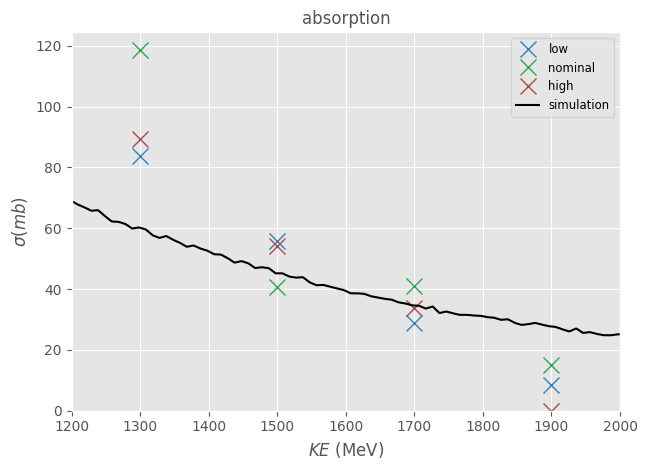

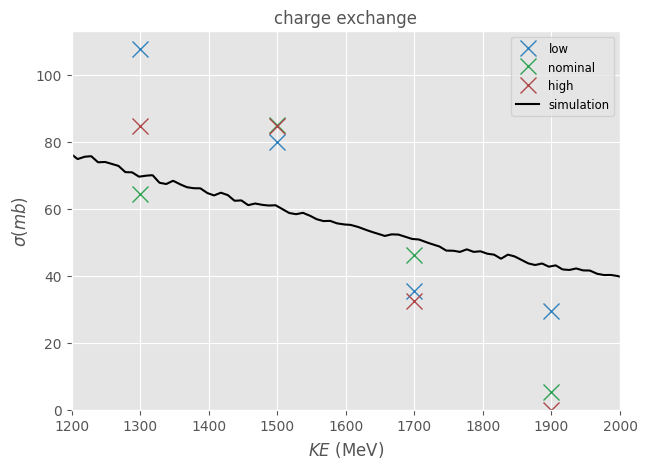

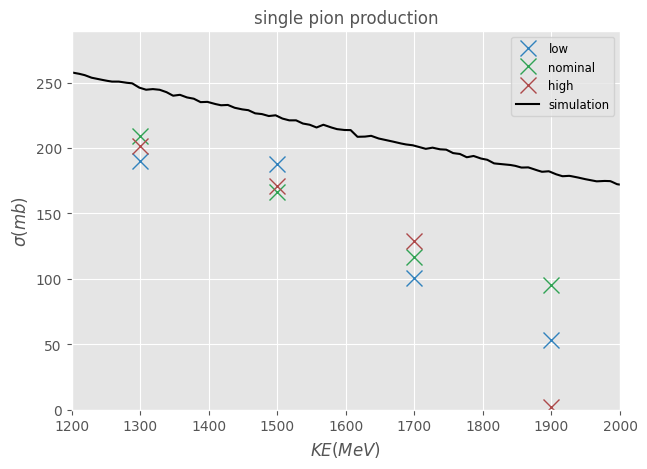

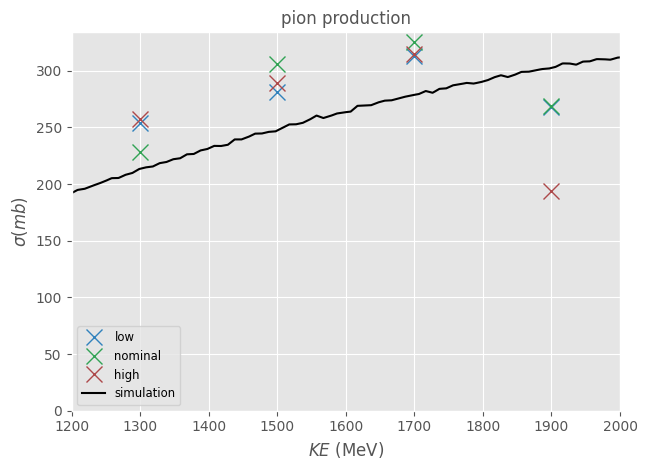

In [39]:
xs_nominal = cross_section.LoadObject("work/2023/beam_selections/new_selection_true/measurement/xs.dill")

upl.PlotResults(xs_nominal, result)

In [36]:
err_asym = upl.CalculateSysErrorAsym(xs_nominal, result)
# err_asym = cross_section.LoadObject("work/2023/beam_selections/new_selection_true/systematics/upstream/sys.dill")["systematic"]

In [37]:
tables = upl.DataAnalysisTables(xs_nominal, err_asym, "Upstream")

tables

{'absorption':   $KE$ (MeV)     Total Data stat Upstream low Upstream high
 0       1300  0.366307  0.221217     0.291965           0.0
 1       1500  0.415055  0.181742          0.0      0.373149
 2       1700  0.364263  0.209582     0.297931           0.0
 3       1900  1.908447  1.626032     0.999095           0.0
 4    average  0.763518  0.559643     0.397248      0.093287,
 'charge_exchange':   $KE$ (MeV)     Total Data stat Upstream low Upstream high
 0       1300  0.724779  0.272141          0.0      0.671747
 1       1500  0.122857  0.108515     0.057604           0.0
 2       1700  0.327627   0.14366     0.294451           0.0
 3       1900  5.405418  2.495661     0.999853      4.689405
 4    average   1.64517  0.754994     0.337977      1.340288,
 'single_pion_production':   $KE$ (MeV)     Total Data stat Upstream low Upstream high
 0       1300  0.224488  0.204882     0.091751           0.0
 1       1500   0.16129  0.093692          0.0      0.131287
 2       1700  0.203355 

{'': 2.832346859102052}

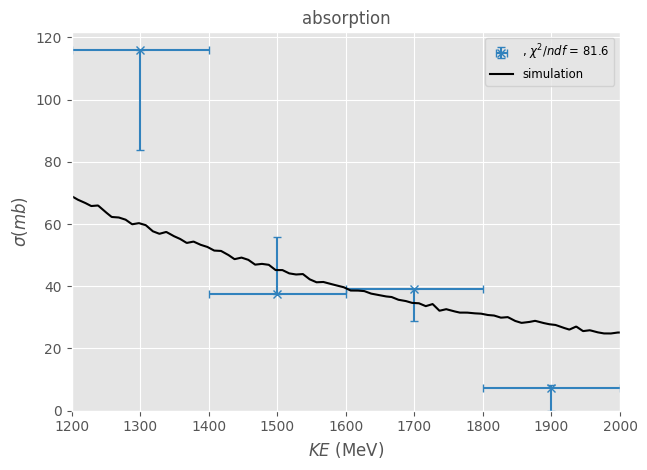

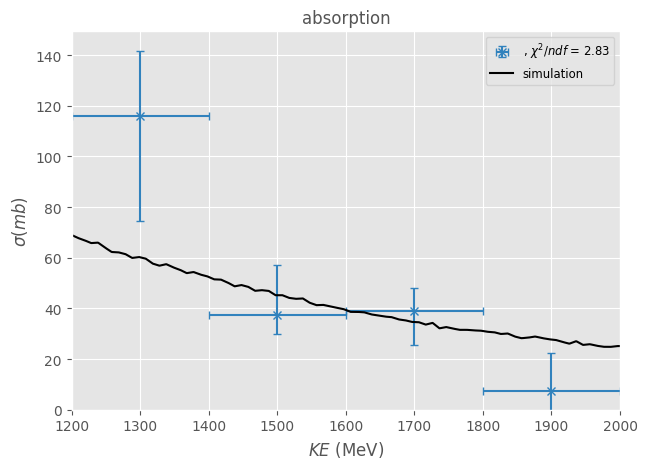

In [189]:
# cross_section.PlotXSComparison({"" : [xs_nominal["pdsp"]["absorption"][0], err]}, args.energy_slices, "absorption")

# err_total = [cross_section.quadsum([xs_nominal["pdsp"]["absorption"][1], err[0]], 0), cross_section.quadsum([xs_nominal["pdsp"]["absorption"][1], err[1]], 0)]

# cross_section.PlotXSComparison({"" : [xs_nominal["pdsp"]["absorption"][0], err_total]}, args.energy_slices, "absorption")


In [32]:
brw = cex_systematics.BeamReweightSystematic(args_low)
brw.CreateNewAIs("test/")

{
    'p0': {'value': 1.303305814031486, 'error': 0.09094711386913885},
    'p1': {'value': 1967.2159302419866, 'error': 13.017072167498572},
    'p2': {'value': 140.02614627718154, 'error': 12.235907176859273}
}

{
    'p0': {'value': 1.4852000417697637, 'error': 0.09094711386913885},
    'p1': {'value': 1993.2500745769837, 'error': 13.017072167498572},
    'p2': {'value': 164.4979606309001, 'error': 12.235907176859273}
}

In [28]:
ai_low = cross_section.AnalysisInput.FromFile("test/beam_reweight_1_sigma_low/analysis_input/analysis_input_mc_selected.dill")
ai_high = cross_section.AnalysisInput.FromFile("test/beam_reweight_1_sigma_high/analysis_input/analysis_input_mc_selected.dill")
ai_nominal = cross_section.AnalysisInput.FromFile("work/2023/analysis_2GeV_new_pfo_selection/analysis_input/analysis_input_mc_selected.dill")

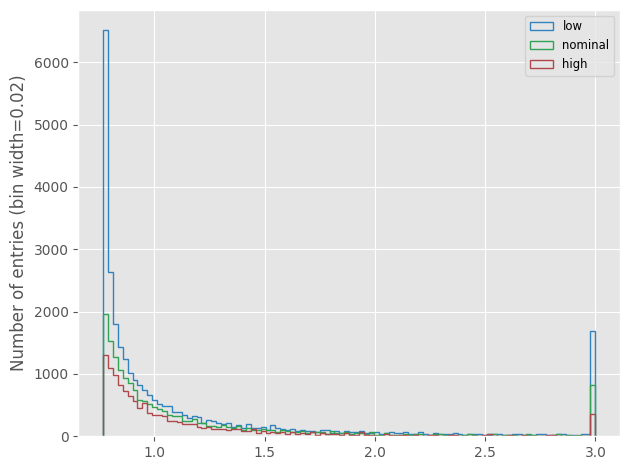

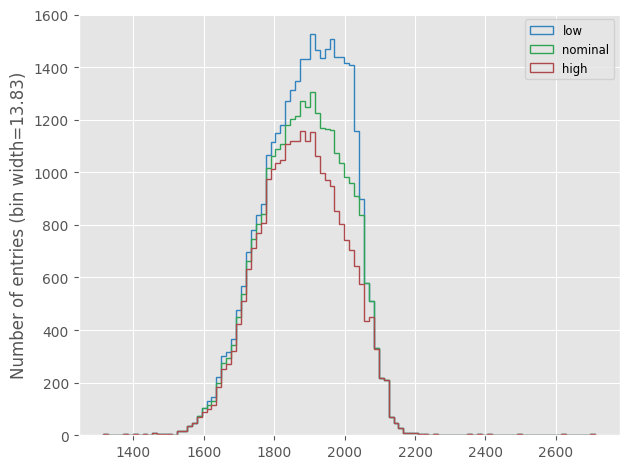

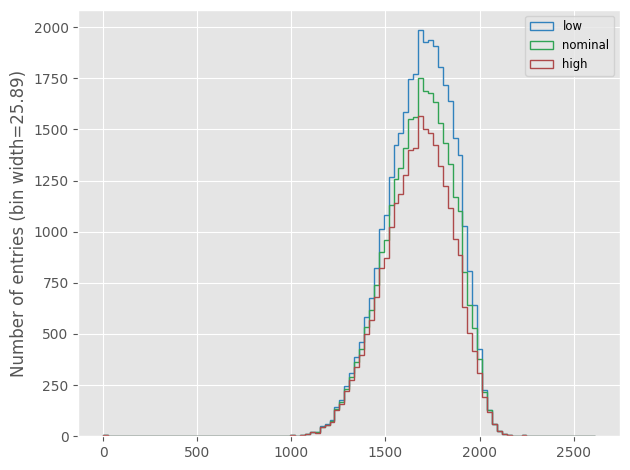

In [35]:
Plots.PlotHistComparison([ai_low.weights, ai_nominal.weights, ai_high.weights], labels = ["low", "nominal", "high"], density = False)
Plots.PlotHistComparison([ai_low.KE_init_reco, ai_nominal.KE_init_reco, ai_high.KE_init_reco], labels = ["low", "nominal", "high"], density = False, weights = [ai_low.weights, ai_nominal.weights, ai_high.weights])
Plots.PlotHistComparison([ai_low.KE_int_reco, ai_nominal.KE_int_reco, ai_high.KE_int_reco], labels = ["low", "nominal", "high"], density = False, weights = [ai_low.weights, ai_nominal.weights, ai_high.weights])


# Plotting systematics

In [4]:
args = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration("work/2023/analysis_2GeV_new_pfo_selection/analysis_config.json"))

In [5]:
cv = cross_section.LoadObject("work/2023/analysis_2GeV_new_pfo_selection/measurement/xs.dill")["pdsp"]
print(cv)

{
    'absorption': (
        array([  0.2439712 ,  39.34807752,  49.23403351, 111.9130018 ]),
        array([ 4.87847486, 14.29853574, 14.13702538, 42.13325135])
    ),
    'charge_exchange': (
        array([ 4.61174657, 58.3567793 , 92.86561983, 82.30241564]),
        array([ 4.46941532,  8.50849259, 13.12952041, 31.33916911])
    ),
    'single_pion_production': (
        array([  3.85378099, 132.74128263, 164.98966971, 267.87113074]),
        array([ 8.18427147, 20.06654649, 25.53370588, 89.81458957])
    ),
    'pion_production': (
        array([345.9957019 , 339.92526356, 293.34396236, 234.40688921]),
        array([37.73619733, 20.37188662, 27.58066458, 74.72679591])
    )
}

In [6]:
label_short = {
    'absorption': "abs",
    'charge_exchange': "cex",
    'single_pion_production': "spip",
    'pion_production': "pip"
}

systematics = {}
for f in cross_section.os.listdir("work/2023/analysis_2GeV_new_pfo_selection/systematics/"):
    sys = cross_section.LoadObject(f"work/2023/analysis_2GeV_new_pfo_selection/systematics/{f}/sys.dill")
    if f == "theory":
        t = cex_systematics.TheoryXS(sys, cv)
        systematics =  {**systematics, **{f"theory, {label_short[k]}" : t[k] for k in t}}
    if f == "upstream":
        systematics[f] = sys["systematic"]
print(systematics)

{
    'theory, abs': {
        'absorption': array([[9.51130298e-03, 5.36639049e-01, 3.80839138e+00, 8.85383883e+00],
       [6.48345006e-03, 1.70071654e+00, 4.15246573e+00, 6.11357287e+00]]),
        'charge_exchange': array([[9.34565246e-03, 1.76871618e-02, 4.78220489e+00, 1.03912272e+01],
       [9.68900319e-03, 1.73680996e+00, 3.54022622e+00, 4.62532638e+00]]),
        'single_pion_production': array([[ 0.01964757,  1.02523748,  6.13492877, 13.02696043],
       [ 0.0162919 ,  2.56838454,  3.53056496,  2.573148  ]]),
        'pion_production': array([[ 0.04513664,  4.04563701,  2.51188748,  6.04896745],
       [ 0.03238748,  0.21379665,  7.07697346, 15.73604219]])
    },
    'theory, cex': {
        'absorption': array([[0.43940014, 1.34513419, 0.86313504, 3.25931092],
       [0.50355258, 1.50212138, 0.8869999 , 1.36883561]]),
        'charge_exchange': array([[0.60427435, 1.03898756, 0.58024708, 1.37871861],
       [0.50414841, 1.61663649, 0.50704329, 3.02132075]]),
        'single_pion_production': array([[0.50118426, 1.41265968, 1.71920082, 2.32261824],
       [0.28410832, 1.6412661 , 1.0369016 , 1.55462267]]),
        'pion_production': array([[0.0448754 , 1.53856787, 1.96253531, 2.14929076],
       [0.53992891, 1.1797645 , 1.10305871, 3.13779103]])
    },
    'theory, spip': {
        'absorption': array([[ 0.23394467,  0.38456241,  2.91504692, 14.96083806],
       [ 0.21776995,  0.60019328,  1.48065185, 10.19965975]]),
        'charge_exchange': array([[ 0.24225812,  0.80615776,  2.32054991, 13.915395  ],
       [ 0.22531503,  0.81513871,  1.49931611, 10.56035237]]),
        'single_pion_production': array([[ 0.25537443,  1.52141818,  1.50278341, 11.83947286],
       [ 0.26367215,  1.21955478,  1.27455691, 10.92679661]]),
        'pion_production': array([[ 0.25711653,  0.97605843,  0.9591159 ,  6.86939477],
       [ 0.32470951,  1.6549409 ,  2.34258213, 15.79327762]])
    },
    'theory, pip': {
        'absorption': array([[2.79696425, 1.70235725, 2.87268708, 6.42246184],
       [0.97851925, 0.5755436 , 2.9689916 , 2.79071409]]),
        'charge_exchange': array([[2.33625139, 0.97242079, 3.34206887, 6.2731035 ],
       [1.31175544, 0.62127679, 3.09901513, 3.6113643 ]]),
        'single_pion_production': array([[2.35700175, 1.39005335, 4.52597497, 9.62655789],
       [0.09546292, 0.22178938, 3.12061834, 2.28346835]]),
        'pion_production': array([[ 8.33473474,  1.54752793,  0.88854179,  4.19707029],
       [ 2.79983449,  2.03134052,  4.47012376, 11.6247116 ]])
    },
    'upstream': {
        'absorption': array([0.81290633, 4.48625372, 3.67142281, 3.87303547]),
        'charge_exchange': array([5.1824686 , 1.31322773, 0.47008924, 2.52829148]),
        'single_pion_production': array([1.40128434, 2.66899165, 4.40929109, 2.21437744]),
        'pion_production': array([2.19448318, 1.54348334, 4.19272024, 1.14029256])
    }
}

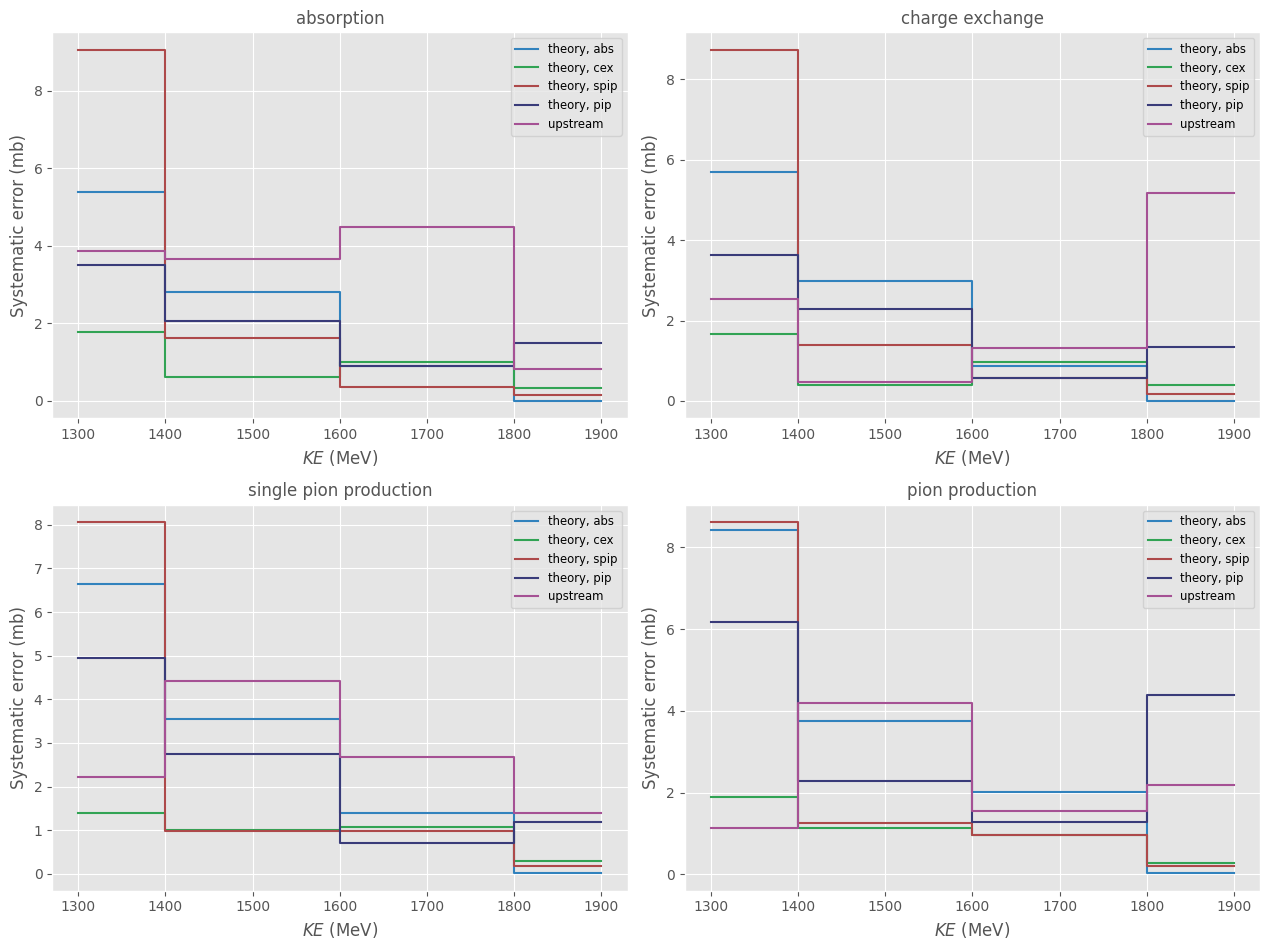

In [7]:
cex_systematics.PlotSysHist(systematics, args.energy_slices)

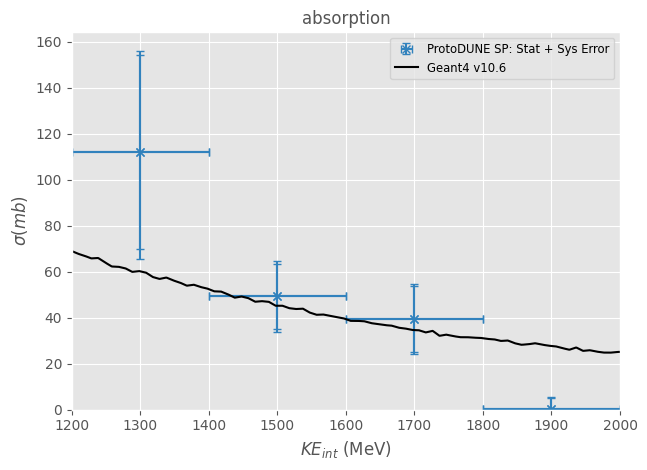

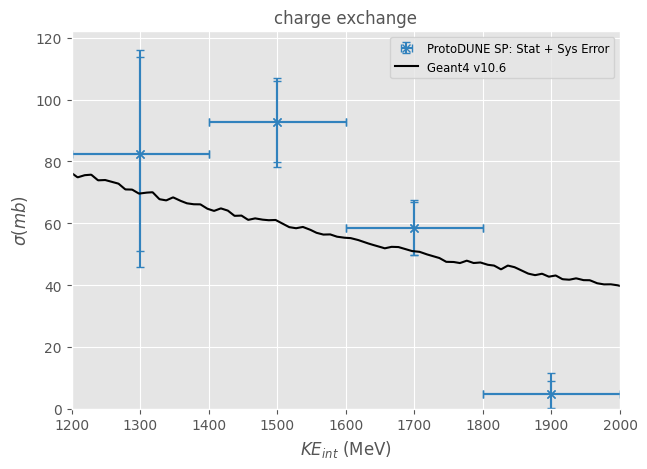

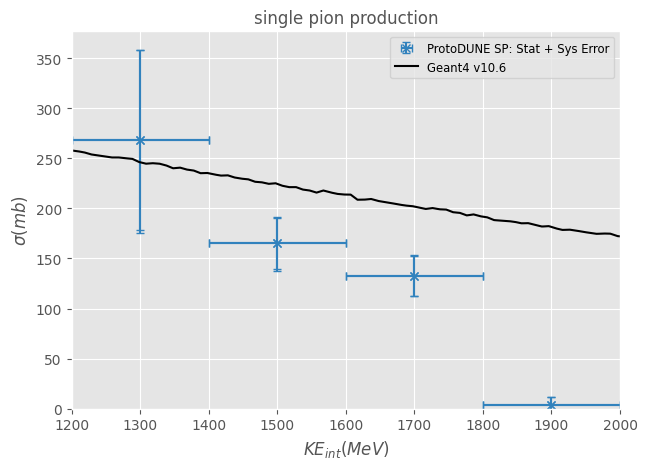

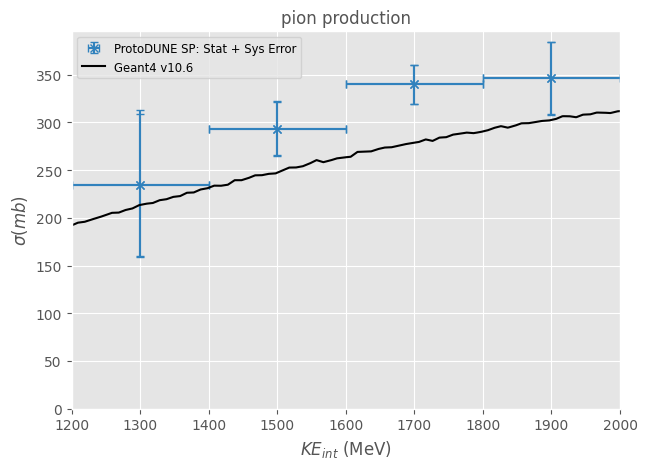

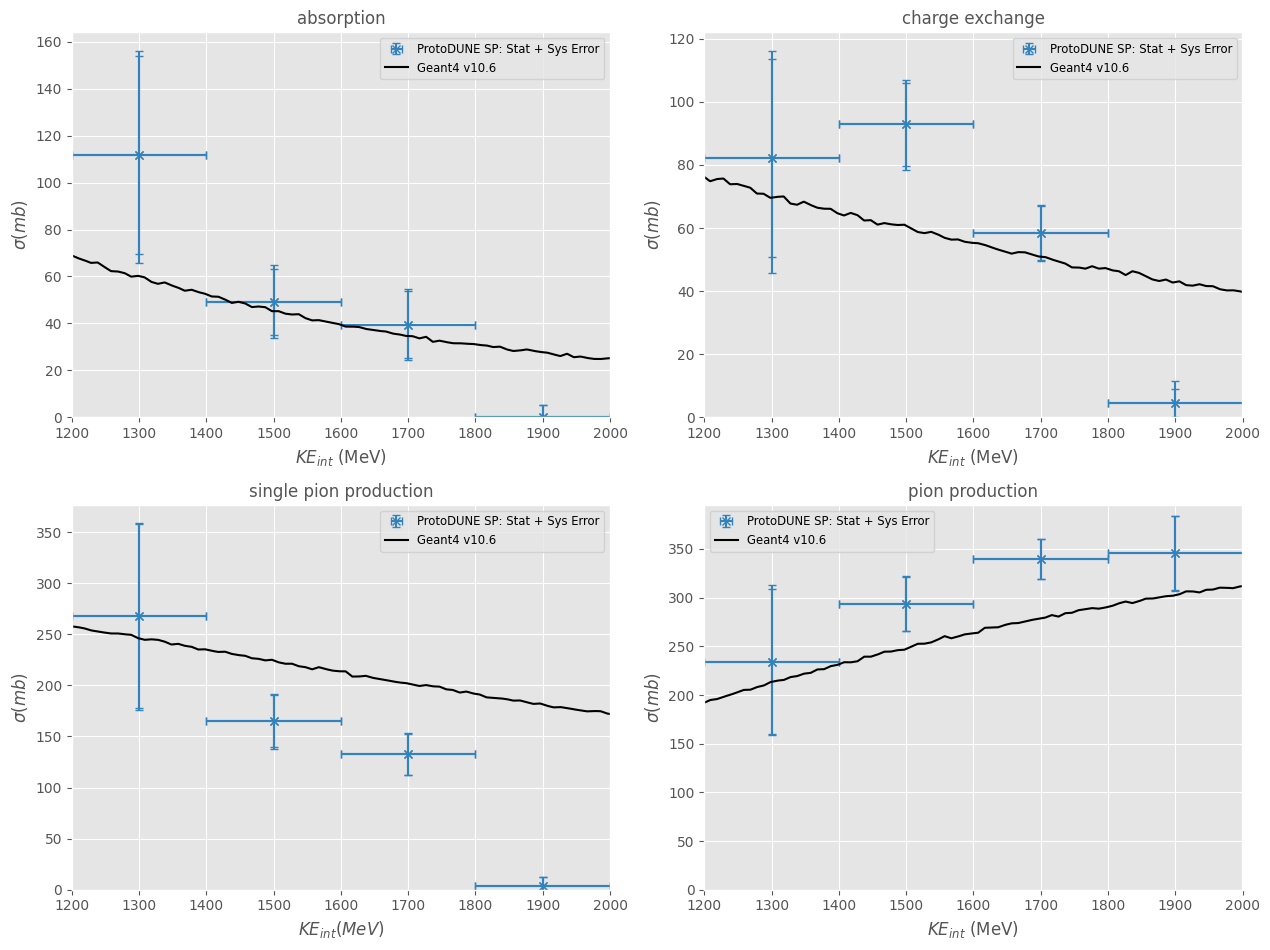

In [130]:
cex_systematics.FinalPlots(cv, systematics, args.energy_slices)

# background subtraction propagation

In [36]:
mc = cross_section.AnalysisInput.FromFile("work/2023/analysis_2GeV_new_pfo_selection/analysis_input/analysis_input_mc_selected.dill")
data = cross_section.AnalysisInput.FromFile("work/2023/analysis_2GeV_new_pfo_selection/analysis_input/analysis_input_data_selected.dill")

region_fit_result, fit_values = cex_analyse.RegionFit(data, args.energy_slices, None, mc, return_fit_results = True, mc_stat_unc = args.fit["mc_stat_unc"], single_bin = args.fit["single_bin"])



  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']
     nbins: {'channel_0': 1, 'channel_1': 1, 'channel_2': 1, 'channel_3': 1}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 0
   auxdata: []
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-23307.15740486])


In [40]:
bkg, bkg_err = cross_section.RegionFit.EstimateBackgroundInRegions(region_fit_result, data)

templates_energy = cross_section.RegionFit.CreateKEIntTemplates(mc, args.energy_slices, False, False)


In [52]:
theory_err = np.array(templates_energy) * 0.2

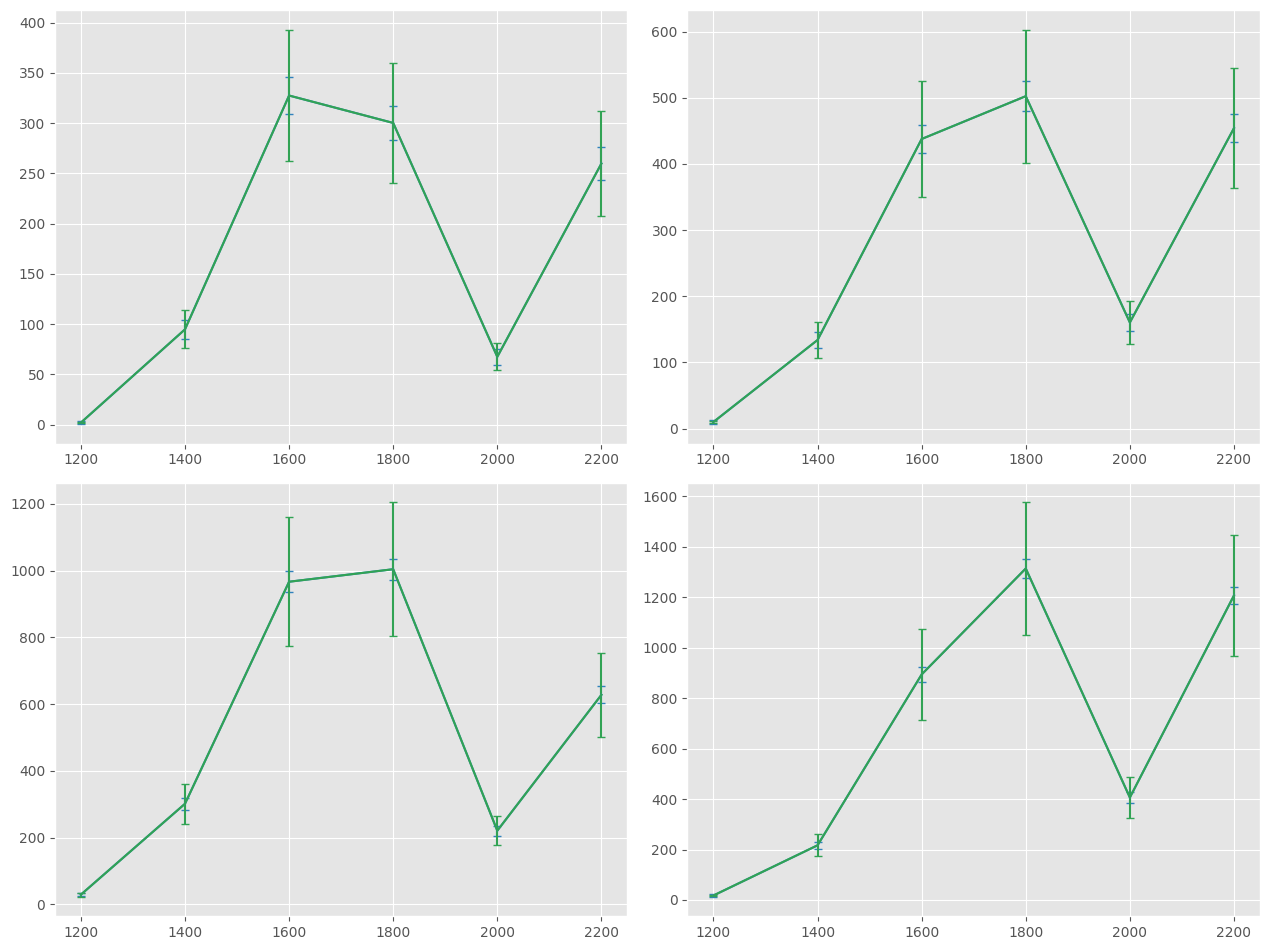

In [59]:
for p in Plots.MultiPlot(len(theory_err[0])):
    Plots.Plot(args.energy_slices.pos_overflow, templates_energy[0][p], yerr = np.sqrt(templates_energy[0][p]), newFigure = False)
    Plots.Plot(args.energy_slices.pos_overflow, templates_energy[0][p], yerr = theory_err[0][p], newFigure = False)

# Shower energy correction

In [2]:
from apps import cex_analysis_input

args = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration("test/test_new_file_structure/analysis_config.json"))

In [3]:
args.selection_masks["mc"]["beam"]#["/home/sb16165/Documents/pi0-analysis/analysis/work/ROOTFiles/PDSPAnalyser/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_ExtraStats_v09_82_01d00.root"]

{'/home/sb16165/Documents/pi0-analysis/analysis/work/ROOTFiles/PDSPAnalyser/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_ExtraStats_v09_82_01d00.root': {'PiBeamSelection': <Array [False, False, True, ... True, True] type='16281 * bool'>,
  'PandoraTagCut': <Array [False, True, True, ... True, True] type='16281 * bool'>,
  'CaloSizeCut': <Array [False, True, True, ... True, True] type='16281 * bool'>,
  'HasFinalStatePFOsCut': <Array [False, True, True, ... True, True] type='16281 * bool'>,
  'DxyCut': <Array [False, True, True, ... True, True] type='16281 * bool'>,
  'DzCut': <Array [False, True, True, ... True, False] type='16281 * bool'>,
  'CosThetaCut': <Array [False, False, True, ... True, False] type='16281 * bool'>,
  'APA3Cut': <Array [True, True, True, ... True, True, True] type='16281 * bool'>,
  'MichelScoreCut': <Array [False, True, True, ... True, True] type='16281 * bool'>,
  'MedianDEdXCut': <Array [True, True, True, ... True, False] type='16281 * bool'>,
  'BeamScr

In [4]:
sc = cex_systematics.ShowerEnergyCorrectionSystematic(args)

In [5]:
sc.CreateAltPi0Selections()

total_events=16281

batches=[16281]

/home/sb16165/Documents/pi0-analysis/analysis/work/ROOTFiles/PDSPAnalyser/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v
1_ntuple_ExtraStats_v09_82_01d00.root 16281 0

KeyError: '/home/sb16165/Documents/pi0-analysis/analysis/work/ROOTFiles/PDSPAnalyser/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_ExtraStats_v09_82_01d00.root'

In [10]:
cross_section.os.makedirs("test/sc/", exist_ok = True)
sc.CreateNewAIs("test/sc/")

'BeamPionSelection' executed in 0.0266s

'BeamPionSelection' executed in 0.1203s

no truth information found, sorting showers by reco energy instead

no truth information found, sorting showers by reco energy instead

no truth information found, sorting showers by reco energy instead

no truth information found, sorting showers by reco energy instead

'BeamPionSelection' executed in 0.0272s

'RegionSelection' executed in 7.5025s

'RecoDepositedEnergy' executed in 9.9988s

'RecoDepositedEnergy' executed in 9.2814s

'BeamPionSelection' executed in 0.1209s

'RegionSelection' executed in 4.5564s

'RecoDepositedEnergy' executed in 41.8037s

'BeamPionSelection' executed in 0.0287s

'RegionSelection' executed in 7.0849s

'RecoDepositedEnergy' executed in 8.6866s

'RecoDepositedEnergy' executed in 10.1015s

'BeamPionSelection' executed in 0.0972s

'RegionSelection' executed in 4.5209s

'RecoDepositedEnergy' executed in 30.1668s

In [11]:
sc_ai = {
    "low" : cross_section.AnalysisInput.FromFile("test/sc/shower_energy_correction_1_sigma_low/analysis_input/analysis_input_mc_selected.dill"),
    "high" : cross_section.AnalysisInput.FromFile("test/sc/shower_energy_correction_1_sigma_high/analysis_input/analysis_input_mc_selected.dill")
}

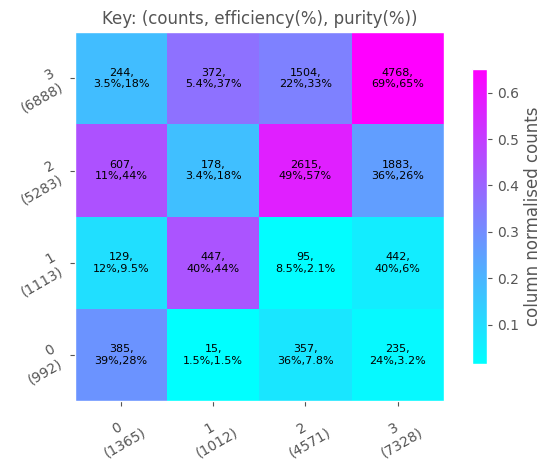

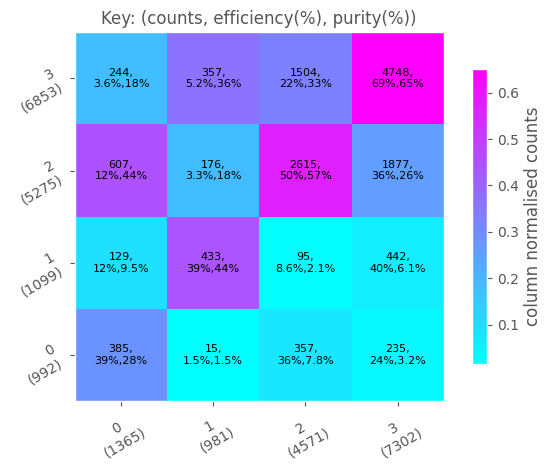

In [21]:
for ai in sc_ai:
    counts = cross_section.CountInRegions(sc_ai[ai].exclusive_process, sc_ai[ai].regions)

    Plots.PlotConfusionMatrix(counts)


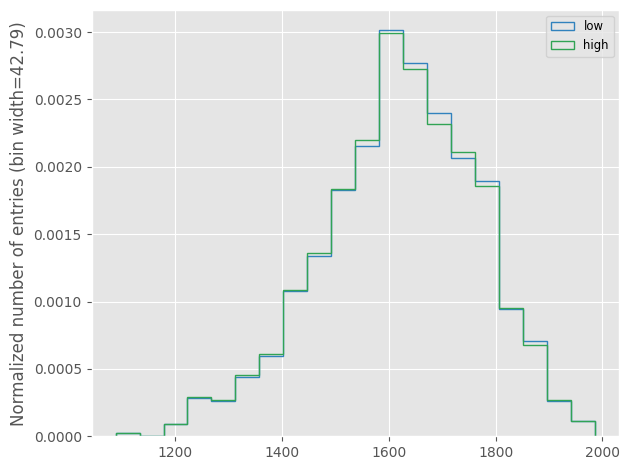

In [20]:
Plots.PlotHistComparison([sc_ai[ai].KE_int_reco[sc_ai[ai].regions["charge_exchange"]] for ai in sc_ai], labels = list(sc_ai.keys()), bins = 20)

# track length resolution

In [72]:
args = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration("work/2023/beam_selections/new_selection_true/analysis_config.json"))

-0.013201320132013201

0.012751275127512752

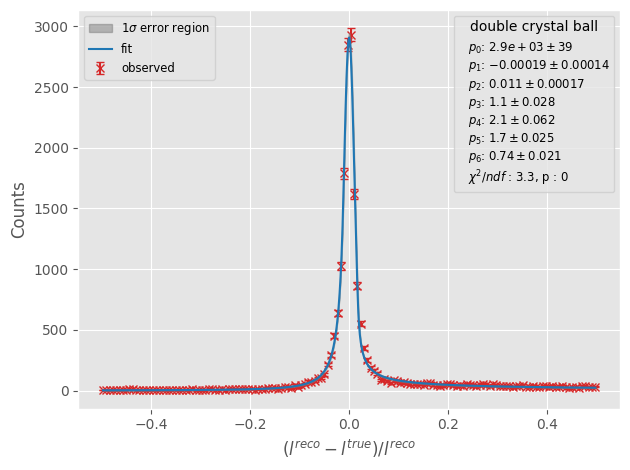

In [96]:
trk = TrackLengthResolutionSystematic(args)

trk.CalculateResolution()

In [97]:
trk.CreateNewAIs("test/trk_sys/")

In [100]:
result = trk.RunAnalysis("test/trk_sys/")

loading Data and MC

analysing pdsp

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:890: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']
     nbins: {'channel_0': 1, 'channel_1': 1, 'channel_2': 1, 'channel_3': 1}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 0
   auxdata: []
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-13878.39589066])


fit_values.bestfit=array([2.54298922, 2.81476587, 1.83291575, 3.25231619])

init
Iteration 1: ts = 0.0058, ts_stopping = 0.0001
Iteration 2: ts = 0.0048, ts_stopping = 0.0001
Iteration 3: ts = 0.0038, ts_stopping = 0.0001
Iteration 4: ts = 0.0029, ts_stopping = 0.0001
Iteration 5: ts = 0.0022, ts_stopping = 0.0001
Iteration 6: ts = 0.0017, ts_stopping = 0.0001
int
Iteration 1: ts = 0.0062, ts_stopping = 0.0001
Iteration 2: ts = 0.0051, ts_stopping = 0.0001
Iteration 3: ts = 0.0042, ts_stopping = 0.0001
Iteration 4: ts = 0.0034, ts_stopping = 0.0001
Iteration 5: ts = 0.0028, ts_stopping = 0.0001
Iteration 6: ts = 0.0022, ts_stopping = 0.0001
absorption
Iteration 1: ts = 0.1019, ts_stopping = 0.0001
Iteration 2: ts = 0.0608, ts_stopping = 0.0001
Iteration 3: ts = 0.0325, ts_stopping = 0.0001
Iteration 4: ts = 0.0188, ts_stopping = 0.0001
Iteration 5: ts = 0.0119, ts_stopping = 0.0001
Iteration 6: ts = 0.0087, ts_stopping = 0.0001
charge_exchange
Iteration 1: ts = 0.0756, ts_stopping = 0.0001
Iteration 2: ts = 0.0313, ts_stopping = 0.0001
Iteration 3: ts = 0.0132

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:1813: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  Plots.plt.figure()
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:994: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:890: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


process={'absorption': (array([ 28.82010829,  37.39689435,  34.89393414, 129.7499448 ]), array([21.17038806,  
7.77683663,  6.37304769, 24.88664873])), 'charge_exchange': (array([ 2.36391255, 43.48923874, 85.50200629, 
63.85608939]), array([ 7.80296954,  6.25382646,  8.58999246, 15.21250256])), 'single_pion_production': (array([ 
91.78170359, 112.38819824, 161.79052372, 205.69896348]), array([34.70955791, 11.9491004 , 14.20765036, 
36.87679193])), 'pion_production': (array([253.80678357, 322.19039209, 290.25455966, 241.1418617 ]), 
array([38.39519573, 15.79279772, 17.61030333, 41.91142974]))}

loading Data and MC

analysing pdsp

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']
     nbins: {'channel_0': 1, 'channel_1': 1, 'channel_2': 1, 'channel_3': 1}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 0
   auxdata: []
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-13878.39589066])


fit_values.bestfit=array([2.54298922, 2.81476587, 1.83291575, 3.25231619])

init
Iteration 1: ts = 0.0170, ts_stopping = 0.0001
Iteration 2: ts = 0.0106, ts_stopping = 0.0001
Iteration 3: ts = 0.0067, ts_stopping = 0.0001
Iteration 4: ts = 0.0043, ts_stopping = 0.0001
Iteration 5: ts = 0.0027, ts_stopping = 0.0001
Iteration 6: ts = 0.0018, ts_stopping = 0.0001
int
Iteration 1: ts = 0.0199, ts_stopping = 0.0001
Iteration 2: ts = 0.0091, ts_stopping = 0.0001
Iteration 3: ts = 0.0045, ts_stopping = 0.0001
Iteration 4: ts = 0.0024, ts_stopping = 0.0001
Iteration 5: ts = 0.0013, ts_stopping = 0.0001
Iteration 6: ts = 0.0007, ts_stopping = 0.0001
absorption
Iteration 1: ts = 0.0449, ts_stopping = 0.0001
Iteration 2: ts = 0.0262, ts_stopping = 0.0001
Iteration 3: ts = 0.0144, ts_stopping = 0.0001
Iteration 4: ts = 0.0082, ts_stopping = 0.0001
Iteration 5: ts = 0.0062, ts_stopping = 0.0001
Iteration 6: ts = 0.0048, ts_stopping = 0.0001
charge_exchange
Iteration 1: ts = 0.0199, ts_stopping = 0.0001
Iteration 2: ts = 0.0101, ts_stopping = 0.0001
Iteration 3: ts = 0.0054

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:1813: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  Plots.plt.figure()
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:994: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:890: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


process={'absorption': (array([ 42.56694095,  40.44879946,  44.93902131, 114.12642988]), array([27.61365641,  
8.84936055,  8.29319175, 30.64389813])), 'charge_exchange': (array([ 5.57102651, 48.80891097, 89.38387354, 
60.76325746]), array([11.44380552,  7.05728284, 10.14101504, 19.91945613])), 'single_pion_production': 
(array([100.05303676, 119.5691334 , 173.69149642, 200.18391728]), array([35.43195974, 13.02432962, 17.2963914 , 
49.88430737])), 'pion_production': (array([253.36652634, 337.90900194, 318.98824986, 216.58416006]), 
array([39.22326545, 17.94393331, 22.612402  , 52.57936618]))}

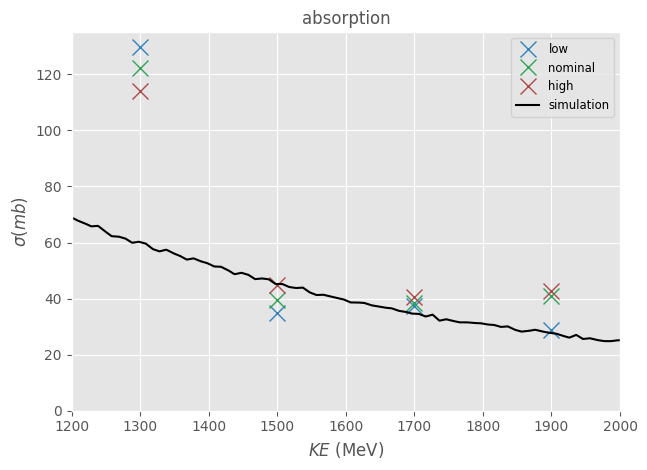

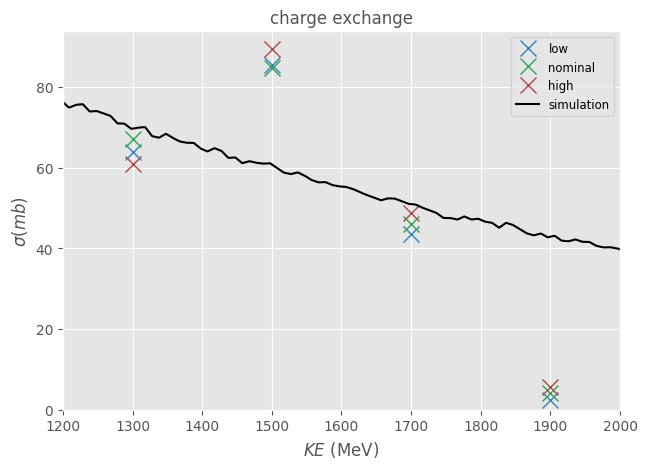

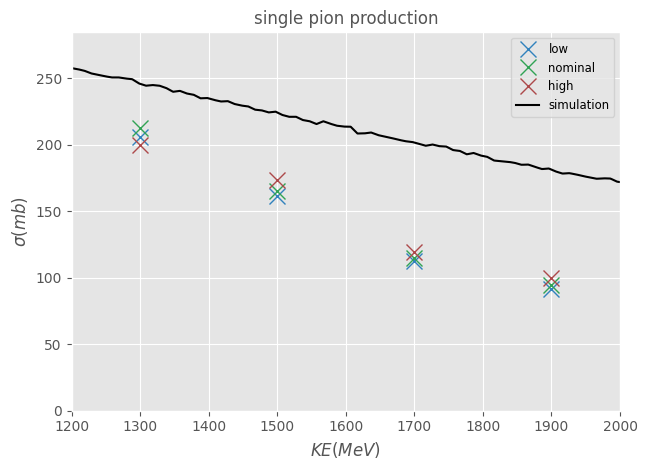

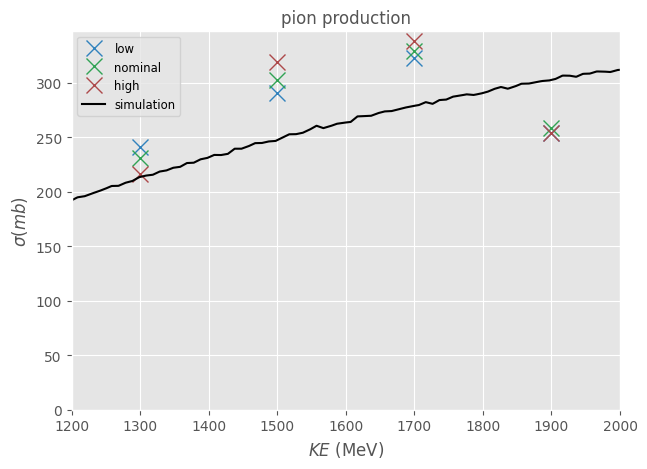

In [101]:
trk.PlotResults(cross_section.LoadObject("work/2023/beam_selections/new_selection_true/measurement/xs.dill"), result)

In [110]:
tables = trk.DataAnalysisTables(
    cross_section.LoadObject("work/2023/beam_selections/new_selection_true/measurement/xs.dill"),
    trk.CalculateSysErrorAsym(cross_section.LoadObject("work/2023/beam_selections/new_selection_true/measurement/xs.dill"), result), "track length")

print(tables)

{
    'absorption':   $KE$ (MeV)     Total Data stat track length low track length high
0       1300  0.242269  0.224744         0.065857          0.062024
1       1500  0.258551  0.185336         0.117101          0.137064
2       1700  0.228609  0.220689         0.025664           0.05385
3       1900  0.732494  0.667899         0.298608          0.035947
4    average  0.365481  0.324667         0.126807          0.072221,
    'charge_exchange':   $KE$ (MeV)     Total Data stat track length low track length high
0       1300  0.291186  0.276074         0.092585               0.0
1       1500  0.121532  0.108313              0.0          0.055123
2       1700   0.16626  0.144711          0.05483          0.060785
3       1900  2.407648  2.343021         0.424635          0.355961
4    average  0.746656  0.718029         0.143013          0.117967,
    'single_pion_production':   $KE$ (MeV)     Total Data stat track length low track length high
0       1300  0.217413  0.209365         0.058606               0.0
1       1500  0.107988  0.093604         0.023294           0.04855
2       1700  0.118169  0.108088         0.018784          0.043909
3       1900  0.379167  0.373559          0.02962           0.05783
4    average  0.205684  0.196154         0.032576          0.037572,
    'pion_production':   $KE$ (MeV)     Total Data stat track length low track length high
0       1300   0.21758  0.203838         0.061129          0.045326
1       1500  0.094025  0.065278         0.041299          0.053607
2       1700  0.061345  0.051081         0.021244          0.026507
3       1900  0.154921  0.153702         0.019401               0.0
4    average  0.131968  0.118475         0.035768           0.03136
}

# Beam Momentum Resolution

In [3]:
args = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration("work/2023/beam_selections/new_selection_true/analysis_config.json"))

In [4]:
resolution = 2.5/100

bm = cex_systematics.BeamMomentumResolutionSystematic(args)
cross_section.os.makedirs("test/beam_res/", exist_ok = True)
bm.CreateNewAIs("test/beam_res/", resolution)

{'mc': 342, 'data': 1165}

pdf test/beam_res//beam_momentum_resolution_low/beam_reweight/plots/reweight_fits.pdf has been opened


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Fitting.py:108: RuntimeWarning: invalid value encountered in sqrt
  return (p0**2 / p3) * (gamma((p2 + 1)/2) / (np.sqrt(p2 * np.pi) * gamma(p2/2))) * (1 + t**2/p2)**(-(p2 + 1)/2)
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Fitting.py:179: RuntimeWarning: overflow encountered in double_scalars
  A = (n_alpha)**p4 * np.exp(-a_alpha**2 / 2)
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Fitting.py:179: RuntimeWarning: invalid value encountered in double_scalars
  A = (n_alpha)**p4 * np.exp(-a_alpha**2 / 2)
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Utils.py:21: RuntimeWarning: overflow encountered in power
  y = num.astype("complex")**exp


pdf test/beam_res//beam_momentum_resolution_low/beam_reweight/plots/reweight_fits.pdf has been closed
pdf test/beam_res//beam_momentum_resolution_low/beam_reweight/plots/reweight_results_gaussian.pdf has been opened
pdf test/beam_res//beam_momentum_resolution_low/beam_reweight/plots/reweight_results_gaussian.pdf has been closed
pdf test/beam_res//beam_momentum_resolution_low/beam_reweight/plots/reweight_results_student_t.pdf has been opened
pdf test/beam_res//beam_momentum_resolution_low/beam_reweight/plots/reweight_results_student_t.pdf has been closed
pdf test/beam_res//beam_momentum_resolution_low/beam_reweight/plots/reweight_results_poly2d.pdf has been opened
pdf test/beam_res//beam_momentum_resolution_low/beam_reweight/plots/reweight_results_poly2d.pdf has been closed
pdf test/beam_res//beam_momentum_resolution_low/beam_reweight/plots/reweight_results_crystal_ball.pdf has been opened
pdf test/beam_res//beam_momentum_resolution_low/beam_reweight/plots/reweight_results_crystal_ball.

'main' executed in 89.1800s

outputs: test/beam_res//beam_momentum_resolution_low/beam_reweight/

'BeamPionSelection' executed in 0.0471s

pdf test/beam_res//beam_momentum_resolution_low/upstream_loss/cex_upstream_loss_plots.pdf has been opened
pdf test/beam_res//beam_momentum_resolution_low/upstream_loss/cex_upstream_loss_plots.pdf has been closed


fitted parameters : {'value': {'p0': 0.10735552683227803, 'p1': -228.03099617205285}, 'error': {'p0': 
0.0017151477085738294, 'p1': 3.089407645363558}}

outputs: test/beam_res//beam_momentum_resolution_low/upstream_loss/

'BeamPionSelection' executed in 0.0402s

'RegionSelection' executed in 9.4917s

'RecoDepositedEnergy' executed in 13.9130s

'RecoDepositedEnergy' executed in 17.7933s

'BeamPionSelection' executed in 0.1556s

'RegionSelection' executed in 5.9826s

'RecoDepositedEnergy' executed in 49.5313s

{'mc': 342, 'data': 1165}

pdf test/beam_res//beam_momentum_resolution_high/beam_reweight/plots/reweight_fits.pdf has been opened


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Fitting.py:108: RuntimeWarning: invalid value encountered in sqrt
  return (p0**2 / p3) * (gamma((p2 + 1)/2) / (np.sqrt(p2 * np.pi) * gamma(p2/2))) * (1 + t**2/p2)**(-(p2 + 1)/2)
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Fitting.py:108: RuntimeWarning: invalid value encountered in power
  return (p0**2 / p3) * (gamma((p2 + 1)/2) / (np.sqrt(p2 * np.pi) * gamma(p2/2))) * (1 + t**2/p2)**(-(p2 + 1)/2)
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Fitting.py:179: RuntimeWarning: overflow encountered in double_scalars
  A = (n_alpha)**p4 * np.exp(-a_alpha**2 / 2)
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Fitting.py:189: RuntimeWarning: invalid value encountered in multiply
  y = np.where(t > -p3, np.exp(-t**2 / 2), A * Utils.fpower(B - t, -p4))
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Fitting.py:179: RuntimeWarning: invalid value encountered in double_sca

pdf test/beam_res//beam_momentum_resolution_high/beam_reweight/plots/reweight_fits.pdf has been closed
pdf test/beam_res//beam_momentum_resolution_high/beam_reweight/plots/reweight_results_gaussian.pdf has been opened
pdf test/beam_res//beam_momentum_resolution_high/beam_reweight/plots/reweight_results_gaussian.pdf has been closed
pdf test/beam_res//beam_momentum_resolution_high/beam_reweight/plots/reweight_results_student_t.pdf has been opened
pdf test/beam_res//beam_momentum_resolution_high/beam_reweight/plots/reweight_results_student_t.pdf has been closed
pdf test/beam_res//beam_momentum_resolution_high/beam_reweight/plots/reweight_results_poly2d.pdf has been opened
pdf test/beam_res//beam_momentum_resolution_high/beam_reweight/plots/reweight_results_poly2d.pdf has been closed
pdf test/beam_res//beam_momentum_resolution_high/beam_reweight/plots/reweight_results_crystal_ball.pdf has been opened
pdf test/beam_res//beam_momentum_resolution_high/beam_reweight/plots/reweight_results_crys

'main' executed in 87.7444s

outputs: test/beam_res//beam_momentum_resolution_high/beam_reweight/

'BeamPionSelection' executed in 0.0415s

pdf test/beam_res//beam_momentum_resolution_high/upstream_loss/cex_upstream_loss_plots.pdf has been opened
pdf test/beam_res//beam_momentum_resolution_high/upstream_loss/cex_upstream_loss_plots.pdf has been closed


fitted parameters : {'value': {'p0': 0.13505346981809643, 'p1': -192.58358643256966}, 'error': {'p0': 
0.0011815586325437805, 'p1': 2.2260497627078677}}

outputs: test/beam_res//beam_momentum_resolution_high/upstream_loss/

'BeamPionSelection' executed in 0.0423s

'RegionSelection' executed in 10.4004s

'RecoDepositedEnergy' executed in 10.5615s

'RecoDepositedEnergy' executed in 17.1695s

'BeamPionSelection' executed in 0.1136s

'RegionSelection' executed in 6.0324s

'RecoDepositedEnergy' executed in 44.0775s

In [5]:
ai_low = cross_section.AnalysisInput.FromFile("test/beam_res/beam_momentum_resolution_low/analysis_input/analysis_input_data_selected.dill")
ai_nominal = cross_section.AnalysisInput.FromFile(args.analysis_input["data"])
ai_high = cross_section.AnalysisInput.FromFile("test/beam_res/beam_momentum_resolution_high/analysis_input/analysis_input_data_selected.dill")

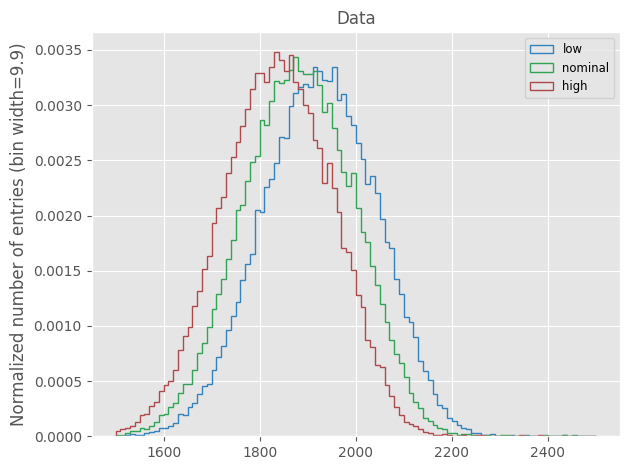

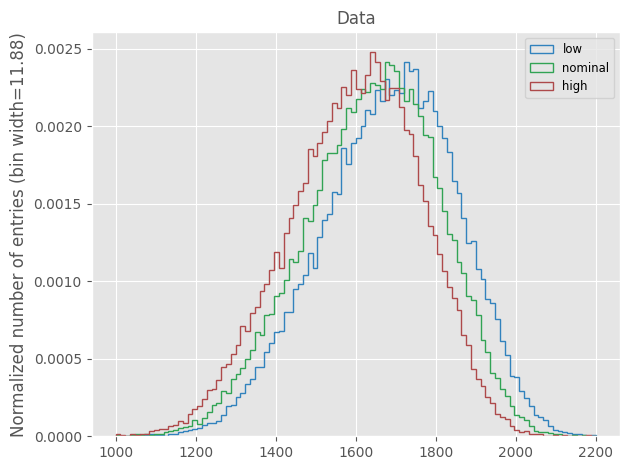

In [9]:
Plots.PlotHistComparison([ai_low.KE_ff_reco, ai_nominal.KE_ff_reco, ai_high.KE_ff_reco], labels = ["low", "nominal", "high"], x_range = args.KE_inst_range, title = "Data")
Plots.PlotHistComparison([ai_low.KE_int_reco, ai_nominal.KE_int_reco, ai_high.KE_int_reco], labels = ["low", "nominal", "high"], x_range = args.KE_int_range, title = "Data")

In [10]:
results = bm.RunAnalysis("test/beam_res/")

loading Data and MC

analysing pdsp

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:890: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']
     nbins: {'channel_0': 1, 'channel_1': 1, 'channel_2': 1, 'channel_3': 1}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('channel_0_stat_err', 'staterror'), ('channel_1_stat_err', 'staterror'), ('channel_2_stat_err', 'staterror'), ('channel_3_stat_err', 'staterror'), ('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['channel_0_stat_err', 'channel_1_stat_err', 'channel_2_stat_err', 'channel_3_stat_err', 'mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 4
   auxdata: [1.0, 1.0, 1.0, 1.0]
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-15688.28451702])


fit_values.bestfit=array([3.06573178, 3.15300376, 2.04974043, 3.37186754, 0.99996464,
       1.00010384, 0.9999845 , 1.00001296])

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:994: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


init
Iteration 1: ts = 0.0596, ts_stopping = 0.001
Iteration 2: ts = 0.0317, ts_stopping = 0.001
Iteration 3: ts = 0.0185, ts_stopping = 0.001
Iteration 4: ts = 0.0117, ts_stopping = 0.001
Iteration 5: ts = 0.0078, ts_stopping = 0.001
Iteration 6: ts = 0.0054, ts_stopping = 0.001
Iteration 7: ts = 0.0039, ts_stopping = 0.001
Iteration 8: ts = 0.0030, ts_stopping = 0.001
Iteration 9: ts = 0.0023, ts_stopping = 0.001
Iteration 10: ts = 0.0018, ts_stopping = 0.001
Iteration 11: ts = 0.0014, ts_stopping = 0.001
Iteration 12: ts = 0.0010, ts_stopping = 0.001
Iteration 13: ts = 0.0008, ts_stopping = 0.001
int
Iteration 1: ts = 0.0482, ts_stopping = 0.001
Iteration 2: ts = 0.0238, ts_stopping = 0.001
Iteration 3: ts = 0.0125, ts_stopping = 0.001
Iteration 4: ts = 0.0069, ts_stopping = 0.001
Iteration 5: ts = 0.0040, ts_stopping = 0.001
Iteration 6: ts = 0.0025, ts_stopping = 0.001
Iteration 7: ts = 0.0016, ts_stopping = 0.001
Iteration 8: ts = 0.0011, ts_stopping = 0.001
Iteration 9: ts = 0.0

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:890: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


process={'absorption': (array([ 45.7629152 ,  43.31094596,  37.85027145, 106.55113937]), array([27.85769737, 
30.68508857, 32.03721192, 67.30129583])), 'charge_exchange': (array([38.62693031, 48.72280824, 78.51307899, 
94.76079539]), array([16.54815728, 21.50308652, 28.34437748, 60.08000817])), 'single_pion_production': 
(array([119.01653787, 122.05883209, 117.24052974, 199.25698891]), array([ 69.54920456,  71.8429449 ,  79.39828737, 
128.27355533])), 'pion_production': (array([331.57117336, 279.90702406, 283.11919306, 249.00192443]), array([ 
39.39869495,  44.11976373,  66.04014239, 136.20246035]))}

loading Data and MC

analysing pdsp

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']
     nbins: {'channel_0': 1, 'channel_1': 1, 'channel_2': 1, 'channel_3': 1}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('channel_0_stat_err', 'staterror'), ('channel_1_stat_err', 'staterror'), ('channel_2_stat_err', 'staterror'), ('channel_3_stat_err', 'staterror'), ('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['channel_0_stat_err', 'channel_1_stat_err', 'channel_2_stat_err', 'channel_3_stat_err', 'mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 4
   auxdata: [1.0, 1.0, 1.0, 1.0]
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-13465.09924225])


fit_values.bestfit=array([2.19954243, 2.72455939, 1.72281038, 3.31667786, 0.9999673 ,
       0.99993831, 0.99995665, 0.99999574])

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:994: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


init
Iteration 1: ts = 0.0330, ts_stopping = 0.001
Iteration 2: ts = 0.0122, ts_stopping = 0.001
Iteration 3: ts = 0.0063, ts_stopping = 0.001
Iteration 4: ts = 0.0042, ts_stopping = 0.001
Iteration 5: ts = 0.0034, ts_stopping = 0.001
Iteration 6: ts = 0.0026, ts_stopping = 0.001
Iteration 7: ts = 0.0020, ts_stopping = 0.001
Iteration 8: ts = 0.0015, ts_stopping = 0.001
Iteration 9: ts = 0.0011, ts_stopping = 0.001
Iteration 10: ts = 0.0008, ts_stopping = 0.001
int
Iteration 1: ts = 0.0228, ts_stopping = 0.001
Iteration 2: ts = 0.0088, ts_stopping = 0.001
Iteration 3: ts = 0.0065, ts_stopping = 0.001
Iteration 4: ts = 0.0060, ts_stopping = 0.001
Iteration 5: ts = 0.0050, ts_stopping = 0.001
Iteration 6: ts = 0.0041, ts_stopping = 0.001
Iteration 7: ts = 0.0033, ts_stopping = 0.001
Iteration 8: ts = 0.0026, ts_stopping = 0.001
Iteration 9: ts = 0.0021, ts_stopping = 0.001
Iteration 10: ts = 0.0017, ts_stopping = 0.001
Iteration 11: ts = 0.0013, ts_stopping = 0.001
Iteration 12: ts = 0.0

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:890: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


process={'absorption': (array([5.09911373e-04, 3.44155620e+01, 4.10678894e+01, 4.76072192e+01]), 
array([2.12490139e-02, 2.86715352e+01, 2.46301608e+01, 2.33464715e+01])), 'charge_exchange': 
(array([2.14733580e-03, 5.58986141e+01, 6.09432717e+01, 1.20635405e+02]), array([ 0.03643542, 26.45035709, 
24.99930622, 33.91199256])), 'single_pion_production': (array([  0.87307814, 106.03894195, 169.67768379, 
158.48533687]), array([ 6.30476068, 67.47338162, 64.95227129, 46.71420355])), 'pion_production': 
(array([271.06258121, 341.86548961, 350.85006831, 224.05011766]), array([86.31659671, 47.07711892, 49.81031286, 
54.43395474]))}

In [11]:
results

{'low': {'absorption': (array([ 45.7629152 ,  43.31094596,  37.85027145, 106.55113937]),
   array([27.85769737, 30.68508857, 32.03721192, 67.30129583])),
  'charge_exchange': (array([38.62693031, 48.72280824, 78.51307899, 94.76079539]),
   array([16.54815728, 21.50308652, 28.34437748, 60.08000817])),
  'single_pion_production': (array([119.01653787, 122.05883209, 117.24052974, 199.25698891]),
   array([ 69.54920456,  71.8429449 ,  79.39828737, 128.27355533])),
  'pion_production': (array([331.57117336, 279.90702406, 283.11919306, 249.00192443]),
   array([ 39.39869495,  44.11976373,  66.04014239, 136.20246035]))},
 'high': {'absorption': (array([5.09911373e-04, 3.44155620e+01, 4.10678894e+01, 4.76072192e+01]),
   array([2.12490139e-02, 2.86715352e+01, 2.46301608e+01, 2.33464715e+01])),
  'charge_exchange': (array([2.14733580e-03, 5.58986141e+01, 6.09432717e+01, 1.20635405e+02]),
   array([ 0.03643542, 26.45035709, 24.99930622, 33.91199256])),
  'single_pion_production': (array([  0.873

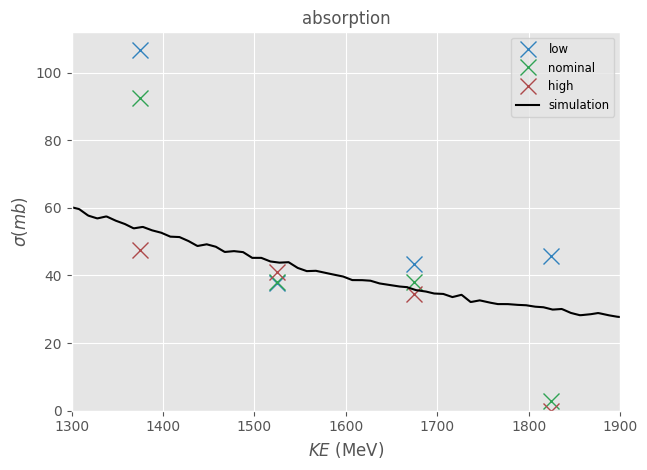

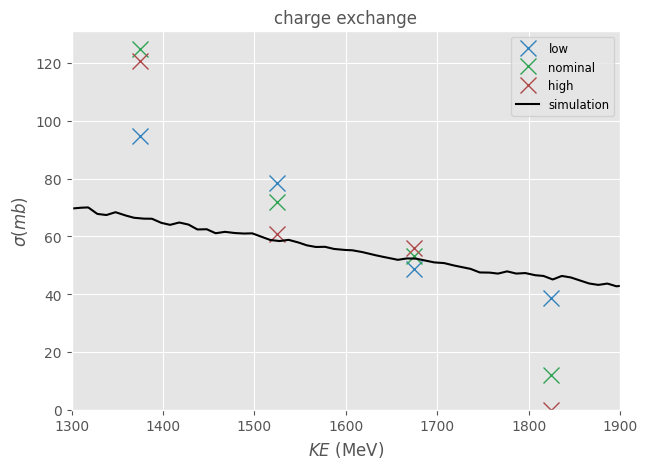

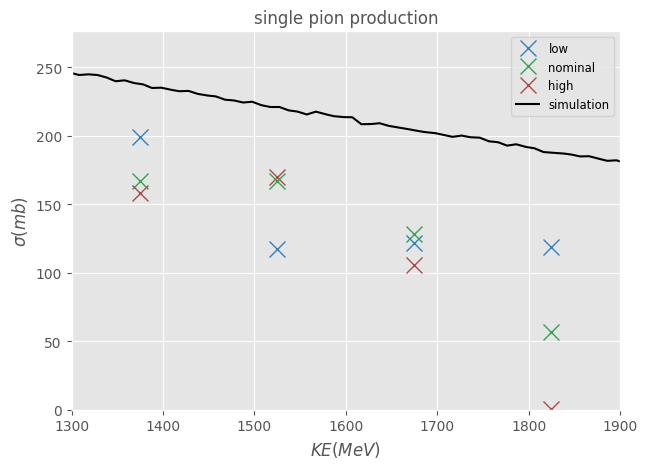

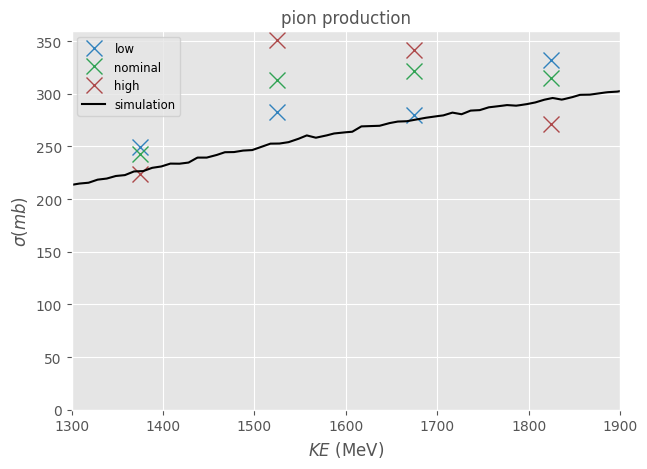

In [12]:
xs_nominal = cross_section.LoadObject("work/2023/beam_selections/new_selection_true/measurement/xs.dill")
bm.PlotResults(xs_nominal, results)